In [1]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg

In [2]:
@njit
def derivative_1d(data, order, h_data, upwind=False):
    num, = data.shape
    ddata = np.zeros_like(data)
    if order == 1:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+1]-data[i])/h_data
            elif i == num-1:
                ddata[i] = (data[i]-data[i-1])/h_data
            else: 
                if upwind == True:
                    ddata[i] = (data[i]-data[i-1])/h_data
                else:
                    ddata[i] = (data[i+1]-data[i-1])/(2*h_data)
    elif order == 2:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+2]-2*data[i+1] + data[i])/(h_data**2)
            elif i == num -1:
                ddata[i] = (data[i]-2*data[i-1] + data[i-2])/(h_data**2)
            else:
                ddata[i] = (data[i+1]- 2*data[i] + data[i-1])/(h_data**2)
    
    return ddata

In [3]:
@njit
def get_coeff(A, Bx, Cxx, D, x_grid, ϕ_prev, ϵ, boundspec):
    dx = x_grid[1] - x_grid[0]
    numx = len(x_grid)
    LHS = np.zeros((numx, numx))
    RHS = -1/ϵ*ϕ_prev - D
    for i in range(numx):
        LHS[i,i] += - 1/ϵ + A[i]
        if i == 0:
            LHS[i,i] += - 1/dx*Bx[i]
            LHS[i,i+1] += 1/dx*Bx[i]
        elif i == numx-1:
            if boundspec[0] == True:
                LHS[i,i] = 1
                RHS[i] = boundspec[1]
            else:
                LHS[i,i] += 1/dx*Bx[i]
                LHS[i,i-1] += -1/dx*Bx[i]
        else:
            LHS[i,i+1] += Bx[i]*(1./dx)*(Bx[i]>0) + Cxx[i]/(dx**2)
            LHS[i,i] += Bx[i]*((-1/dx)*(Bx[i]>0) + (1/dx)*(Bx[i]<0)) - 2*Cxx[i]/(dx**2)
            LHS[i,i-1] += Bx[i]*(-1/dx)*(Bx[i]<0) + Cxx[i]/(dx**2)
    return LHS, RHS

In [4]:
def solve_ode( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec):
    LHS, RHS = get_coeff( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
#     phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [5]:
def false_transient_1d(
    y_grid, z, 
    dmg_params, model_params, bounded=False, bound_var=0, 
    epsilon=0.5, tol = 1e-8, max_iter=10_000,
):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numy, = y_grid.shape
    hy = y_grid[1] - y_grid[0]
    dlambda = gamma_1 + gamma_2*y_grid\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_grid-gamma_bar)*(y_grid>gamma_bar)
    # initiate v and control
    ems = -delta*eta/((eta-1)*dlambda*z)
    error = 1
    episode = 0
    v0 = - delta*eta*y_grid
    
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivative_1d(v0,1,hy, upwind=True)
        # control
        ems_new = -delta*eta/(v0_dy*z + v_n*dlambda*z)
        ems_new[ems_new<=0] = 1e-15
        ems = ems_new*.5 + ems*.5
        A = -delta*np.ones(y_grid.shape)
        By = z*ems
        Cyy = np.zeros(y_grid.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z*ems
        # solve for ODE
        phi_grid = solve_ode(y_grid, A, By, Cyy, D, v0, bound_var, bounded, epsilon)
        phi_grid2 = false_transient_one_iteration_python(
            A, By, Cyy, D, v0, epsilon, hy, (0,bound_var), (False, bounded))
        diff = np.max(abs(phi_grid - phi_grid2))
        rhs = A*phi_grid + By*v0_dy + D
        rhs_error = np.max(abs(rhs))
        error = np.max(abs((phi_grid-v0)/epsilon))
        v0 = phi_grid
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}\t diff: {:.12f}'.format(episode,error,rhs_error,diff))
    return v0, ems

In [7]:
δ = 0.01
η = 0.032
μ = 1.86/1000
ȳ = 2

numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

γ1 = 0.00017675
γ2 = 2*0.0022
γ2p = np.array([0, 2*0.0197])
γbar = 2
dmg_weight = np.array([1, 0])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0015507701573692011,	 ft error: 0.0013554655757295271
episode: 2,	 ode error: 0.0013944201792057969,	 ft error: 0.0012890766500556182
episode: 3,	 ode error: 0.001299636484308969,	 ft error: 0.0012345215390425718
episode: 4,	 ode error: 0.0012367923884590314,	 ft error: 0.0011912406605538856
episode: 5,	 ode error: 0.0011907292220521152,	 ft error: 0.001156075810254932
episode: 6,	 ode error: 0.0011544420579144624,	 ft error: 0.001126573270437606
episode: 7,	 ode error: 0.0011244139906146226,	 ft error: 0.0011011294005619525
episode: 8,	 ode error: 0.001098698555369187,	 ft error: 0.0010787079975184757
episode: 9,	 ode error: 0.0010761267737521489,	 ft error: 0.0010586228265494282
episode: 10,	 ode error: 0.0010559495177003297,	 ft error: 0.0010403707283219107
episode: 11,	 ode error: 0.001037656909618132,	 ft error: 0.001023622140226138
episode: 12,	 ode error: 0.0010208887346232292,	 ft error: 0.0010081205349473732
episode: 13,	 ode error: 0.0010053809639429

episode: 219,	 ode error: 0.00030818373650792026,	 ft error: 0.00030732440635864355
episode: 220,	 ode error: 0.00030637632707684935,	 ft error: 0.00030708564277987427
episode: 221,	 ode error: 0.0003056926338274818,	 ft error: 0.0003045721944317422
episode: 222,	 ode error: 0.0003036497648028397,	 ft error: 0.0003051690447351587
episode: 223,	 ode error: 0.0003032784569872793,	 ft error: 0.00030171101589070626
episode: 224,	 ode error: 0.0003008287600530454,	 ft error: 0.00030058602830583536
episode: 225,	 ode error: 0.00029968334922664047,	 ft error: 0.00030071658080904157
episode: 226,	 ode error: 0.0002991423150062063,	 ft error: 0.00029813908683236356
episode: 227,	 ode error: 0.00029723094515775057,	 ft error: 0.00029844545194545696
episode: 228,	 ode error: 0.00029676477256320257,	 ft error: 0.0002954505983403244
episode: 229,	 ode error: 0.00029457329839891345,	 ft error: 0.00029428119530774494
episode: 230,	 ode error: 0.00029339560984974883,	 ft error: 0.0002941717457005435
e

episode: 457,	 ode error: 0.00011866386685857307,	 ft error: 0.00011858860517464007
episode: 458,	 ode error: 0.00011821162383832899,	 ft error: 0.00011813709955656171
episode: 459,	 ode error: 0.0001177615145292241,	 ft error: 0.00011768716821120943
episode: 460,	 ode error: 0.00011731299555566628,	 ft error: 0.00011723930534846458
episode: 461,	 ode error: 0.00011686652024378596,	 ft error: 0.00011679306902705189
episode: 462,	 ode error: 0.00011642168192848884,	 ft error: 0.00011634882437450608
episode: 463,	 ode error: 0.00011597881542603993,	 ft error: 0.00011590624155517759
episode: 464,	 ode error: 0.00011553761701800719,	 ft error: 0.00011546558875280555
episode: 465,	 ode error: 0.00011509833250201572,	 ft error: 0.00011502662019419649
episode: 466,	 ode error: 0.00011466073537021691,	 ft error: 0.00011458953155652855
episode: 467,	 ode error: 0.00011422500483050874,	 ft error: 0.00011415413985256528
episode: 468,	 ode error: 0.0001137909720557085,	 ft error: 0.000113720586752

episode: 696,	 ode error: 4.8609104334372435e-05,	 ft error: 4.8590521876899315e-05
episode: 697,	 ode error: 4.842991407691128e-05,	 ft error: 4.841144793798121e-05
episode: 698,	 ode error: 4.8251390050404216e-05,	 ft error: 4.8233039761207595e-05
episode: 699,	 ode error: 4.8073529730379826e-05,	 ft error: 4.805529482503068e-05
episode: 700,	 ode error: 4.789633060337678e-05,	 ft error: 4.787821061838042e-05
episode: 701,	 ode error: 4.7719790165954255e-05,	 ft error: 4.770178464066448e-05
episode: 702,	 ode error: 4.754390592533566e-05,	 ft error: 4.7526014401328795e-05
episode: 703,	 ode error: 4.7368675398888724e-05,	 ft error: 4.7350897420597726e-05
episode: 704,	 ode error: 4.719409611442097e-05,	 ft error: 4.717643122817879e-05
episode: 705,	 ode error: 4.702016560953872e-05,	 ft error: 4.700261336467356e-05
episode: 706,	 ode error: 4.6846881432473144e-05,	 ft error: 4.6829441380051115e-05
episode: 707,	 ode error: 4.6674241140682855e-05,	 ft error: 4.665691283473513e-05
epis

episode: 936,	 ode error: 2.0088396047418088e-05,	 ft error: 2.008796692089717e-05
episode: 937,	 ode error: 2.00147586992517e-05,	 ft error: 2.0014375552527646e-05
episode: 938,	 ode error: 1.9941392700776293e-05,	 ft error: 1.9941055359023095e-05
episode: 939,	 ode error: 1.986829704545641e-05,	 ft error: 1.986800533468336e-05
episode: 940,	 ode error: 1.9795470730662643e-05,	 ft error: 1.9795224477439644e-05
episode: 941,	 ode error: 1.972291275745665e-05,	 ft error: 1.9722711789132062e-05
episode: 942,	 ode error: 1.965062213084214e-05,	 ft error: 1.9650466275116428e-05
episode: 943,	 ode error: 1.9578597859195115e-05,	 ft error: 1.957848694472686e-05
episode: 944,	 ode error: 1.950683895486909e-05,	 ft error: 1.950677281088257e-05
episode: 945,	 ode error: 1.943534443377972e-05,	 ft error: 1.9435322890111e-05
episode: 946,	 ode error: 1.9364113315619704e-05,	 ft error: 1.9364136202941012e-05
episode: 947,	 ode error: 1.929314462362165e-05,	 ft error: 1.9293211773023976e-05
episode

episode: 1175,	 ode error: 8.36741341508386e-06,	 ft error: 8.374219142547509e-06
episode: 1176,	 ode error: 8.336871048670647e-06,	 ft error: 8.343695331175516e-06
episode: 1177,	 ode error: 8.306440659016571e-06,	 ft error: 8.3132834261442e-06
episode: 1178,	 ode error: 8.276121833249205e-06,	 ft error: 8.282983015075093e-06
episode: 1179,	 ode error: 8.245914160175116e-06,	 ft error: 8.252793686977511e-06
episode: 1180,	 ode error: 8.215817230038851e-06,	 ft error: 8.222715032341066e-06
episode: 1181,	 ode error: 8.185830634553832e-06,	 ft error: 8.192746643205056e-06
episode: 1182,	 ode error: 8.155953967156496e-06,	 ft error: 8.162888113204722e-06
episode: 1183,	 ode error: 8.126186822483817e-06,	 ft error: 8.133139037316828e-06
episode: 1184,	 ode error: 8.096528797040523e-06,	 ft error: 8.103499012160342e-06
episode: 1185,	 ode error: 8.06697948842834e-06,	 ft error: 8.073967635742012e-06
episode: 1186,	 ode error: 8.037538496165429e-06,	 ft error: 8.044544507664527e-06
episode:

episode: 1413,	 ode error: 3.5097294680965603e-06,	 ft error: 3.519449328984181e-06
episode: 1414,	 ode error: 3.4969605049820504e-06,	 ft error: 3.506687891036142e-06
episode: 1415,	 ode error: 3.4842381331305064e-06,	 ft error: 3.4939730159805338e-06
episode: 1416,	 ode error: 3.471562181484207e-06,	 ft error: 3.4813045327736214e-06
episode: 1417,	 ode error: 3.458932479862009e-06,	 ft error: 3.4686822710886895e-06
episode: 1418,	 ode error: 3.4463488582756486e-06,	 ft error: 3.4561060616629855e-06
episode: 1419,	 ode error: 3.433811148055902e-06,	 ft error: 3.4435757352106284e-06
episode: 1420,	 ode error: 3.4213191804406294e-06,	 ft error: 3.4310911237178665e-06
episode: 1421,	 ode error: 3.4088727878777694e-06,	 ft error: 3.4186520592172087e-06
episode: 1422,	 ode error: 3.3964718030361123e-06,	 ft error: 3.4062583747588677e-06
episode: 1423,	 ode error: 3.3841160592849515e-06,	 ft error: 3.393909903878778e-06
episode: 1424,	 ode error: 3.3718053907398366e-06,	 ft error: 3.3816064

episode: 1651,	 ode error: 1.4752129305653462e-06,	 ft error: 1.4861147276205393e-06
episode: 1652,	 ode error: 1.4698518639458475e-06,	 ft error: 1.4807567127322896e-06
episode: 1653,	 ode error: 1.464510260814028e-06,	 ft error: 1.475418149645321e-06
episode: 1654,	 ode error: 1.4591880500678008e-06,	 ft error: 1.470098967582915e-06
episode: 1655,	 ode error: 1.453885160878081e-06,	 ft error: 1.4647990955139283e-06
episode: 1656,	 ode error: 1.4486015226617896e-06,	 ft error: 1.4595184631473654e-06
episode: 1657,	 ode error: 1.443337065341302e-06,	 ft error: 1.4542569999609345e-06
episode: 1658,	 ode error: 1.4380917184494404e-06,	 ft error: 1.449014636172493e-06
episode: 1659,	 ode error: 1.432865412574931e-06,	 ft error: 1.4437913019073787e-06
episode: 1660,	 ode error: 1.4276580779157538e-06,	 ft error: 1.4385869276610046e-06
episode: 1661,	 ode error: 1.4224696453127121e-06,	 ft error: 1.433401444229469e-06
episode: 1662,	 ode error: 1.4173000456724205e-06,	 ft error: 1.428234782

episode: 1890,	 ode error: 8.172420691084266e-07,	 ft error: 6.285078184518438e-07
episode: 1891,	 ode error: 8.194795088362766e-07,	 ft error: 6.262560971655636e-07
episode: 1892,	 ode error: 8.217088724269284e-07,	 ft error: 6.240125056030296e-07
episode: 1893,	 ode error: 8.239301894154586e-07,	 ft error: 6.21777013973257e-07
episode: 1894,	 ode error: 8.261434888394035e-07,	 ft error: 6.195495930172434e-07
episode: 1895,	 ode error: 8.283487999085791e-07,	 ft error: 6.17330213360338e-07
episode: 1896,	 ode error: 8.305461517944205e-07,	 ft error: 6.151188456972786e-07
episode: 1897,	 ode error: 8.327355731789542e-07,	 ft error: 6.129154610234888e-07
episode: 1898,	 ode error: 8.349170930367243e-07,	 ft error: 6.107200301724847e-07
episode: 1899,	 ode error: 8.370907399916439e-07,	 ft error: 6.085325243478564e-07
episode: 1900,	 ode error: 8.392565426739145e-07,	 ft error: 6.06352914776324e-07
episode: 1901,	 ode error: 8.414145296625633e-07,	 ft error: 6.04181172707737e-07
episode:

episode: 2129,	 ode error: 1.1761598658313784e-06,	 ft error: 2.6733277661006305e-07
episode: 2130,	 ode error: 1.1771051318741187e-06,	 ft error: 2.663816892530443e-07
episode: 2131,	 ode error: 1.1780470069976947e-06,	 ft error: 2.65434014536566e-07
episode: 2132,	 ode error: 1.178985503534364e-06,	 ft error: 2.644897402713046e-07
episode: 2133,	 ode error: 1.1799206335048927e-06,	 ft error: 2.63548854106029e-07
episode: 2134,	 ode error: 1.180852409247285e-06,	 ft error: 2.626113438282859e-07
episode: 2135,	 ode error: 1.181780842869802e-06,	 ft error: 2.6167719708684406e-07
episode: 2136,	 ode error: 1.1827059462948732e-06,	 ft error: 2.607464019468061e-07
episode: 2137,	 ode error: 1.1836277318445646e-06,	 ft error: 2.5981894614945933e-07
episode: 2138,	 ode error: 1.1845462111404392e-06,	 ft error: 2.5889481775990636e-07
episode: 2139,	 ode error: 1.1854613964888423e-06,	 ft error: 2.5797400447317525e-07
episode: 2140,	 ode error: 1.1863732995088432e-06,	 ft error: 2.570564945394

episode: 2368,	 ode error: 1.3281508995767813e-06,	 ft error: 1.1442154237983893e-07
episode: 2369,	 ode error: 1.3285524961964557e-06,	 ft error: 1.1401757221233637e-07
episode: 2370,	 ode error: 1.3289526620591414e-06,	 ft error: 1.1361504170341134e-07
episode: 2371,	 ode error: 1.3293514021552044e-06,	 ft error: 1.1321394569515272e-07
episode: 2372,	 ode error: 1.329748721825316e-06,	 ft error: 1.128142790990383e-07
episode: 2373,	 ode error: 1.330144625949904e-06,	 ft error: 1.1241603671089766e-07
episode: 2374,	 ode error: 1.330539119873326e-06,	 ft error: 1.1201921337281966e-07
episode: 2375,	 ode error: 1.3309322083646623e-06,	 ft error: 1.1162380408880068e-07
episode: 2376,	 ode error: 1.3313238967501643e-06,	 ft error: 1.112298037934482e-07
episode: 2377,	 ode error: 1.3317141897909975e-06,	 ft error: 1.1083720728259176e-07
episode: 2378,	 ode error: 1.3321030927716717e-06,	 ft error: 1.1044600958335742e-07
episode: 2379,	 ode error: 1.3324906105267528e-06,	 ft error: 1.100562

episode: 2607,	 ode error: 1.3928913156137802e-06,	 ft error: 4.930587602554789e-08
episode: 2608,	 ode error: 1.3930629850422357e-06,	 ft error: 4.913323845001649e-08
episode: 2609,	 ode error: 1.393234047489646e-06,	 ft error: 4.896121142775971e-08
episode: 2610,	 ode error: 1.3934045051394858e-06,	 ft error: 4.878979303901687e-08
episode: 2611,	 ode error: 1.393574359926839e-06,	 ft error: 4.861898083204549e-08
episode: 2612,	 ode error: 1.393743614273163e-06,	 ft error: 4.84487728870849e-08
episode: 2613,	 ode error: 1.3939122701235162e-06,	 ft error: 4.827916691430012e-08
episode: 2614,	 ode error: 1.3940803298174986e-06,	 ft error: 4.8110160693245106e-08
episode: 2615,	 ode error: 1.394247795242923e-06,	 ft error: 4.7941752257899914e-08
episode: 2616,	 ode error: 1.3944146686683742e-06,	 ft error: 4.777393924904061e-08
episode: 2617,	 ode error: 1.3945809522323323e-06,	 ft error: 4.7606719885684434e-08
episode: 2618,	 ode error: 1.3947466478700984e-06,	 ft error: 4.74400915773109

episode: 2843,	 ode error: 1.420420438673158e-06,	 ft error: 2.1624869140738728e-08
episode: 2844,	 ode error: 1.4204950949807697e-06,	 ft error: 2.154981336895586e-08
episode: 2845,	 ode error: 1.4205694893809151e-06,	 ft error: 2.147502095132629e-08
episode: 2846,	 ode error: 1.4206436229090074e-06,	 ft error: 2.140049100892346e-08
episode: 2847,	 ode error: 1.420717496333746e-06,	 ft error: 2.1326222524042926e-08
episode: 2848,	 ode error: 1.4207911107198172e-06,	 ft error: 2.1252214594628487e-08
episode: 2849,	 ode error: 1.4208644669220062e-06,	 ft error: 2.1178466388012872e-08
episode: 2850,	 ode error: 1.420937565884111e-06,	 ft error: 2.110497674771376e-08
episode: 2851,	 ode error: 1.4210104084456292e-06,	 ft error: 2.1031745118619643e-08
episode: 2852,	 ode error: 1.4210829956014248e-06,	 ft error: 2.0958770251729618e-08
episode: 2853,	 ode error: 1.4211553281958745e-06,	 ft error: 2.0886051406895e-08
episode: 2854,	 ode error: 1.4212274071398164e-06,	 ft error: 2.08135877051

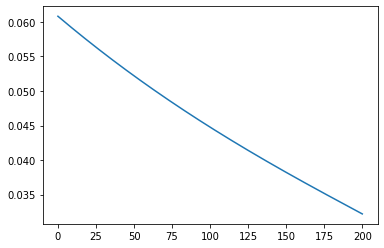

In [8]:
ϕ_low = ϕ
plt.plot(ϕ_low)

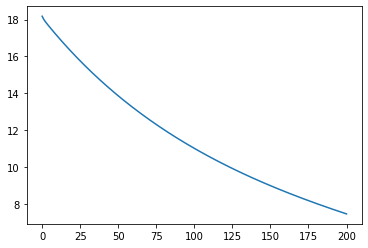

In [9]:
plt.plot(ems)

In [10]:
dmg_weight = np.array([0, 1])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - ȳ)*(y_grid > ȳ)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0015507701864036429,	 ft error: 0.0013554558975822722
episode: 2,	 ode error: 0.0013944203804037657,	 ft error: 0.0012890779160119805
episode: 3,	 ode error: 0.0012996366704325843,	 ft error: 0.0012345228575066387
episode: 4,	 ode error: 0.0012367925531607267,	 ft error: 0.0011912451654915658
episode: 5,	 ode error: 0.0011907293283997152,	 ft error: 0.0011560856903988536
episode: 6,	 ode error: 0.0011544420872006092,	 ft error: 0.0011265905387304917
episode: 7,	 ode error: 0.0011244139470628126,	 ft error: 0.0011011384513851554
episode: 8,	 ode error: 0.001098698319207688,	 ft error: 0.0010787226859847337
episode: 9,	 ode error: 0.0010761259620843636,	 ft error: 0.001058618275535096
episode: 10,	 ode error: 0.001055946474350856,	 ft error: 0.0010403639009321604
episode: 11,	 ode error: 0.0010376515608651643,	 ft error: 0.0010236135180120077
episode: 12,	 ode error: 0.0010208814915040958,	 ft error: 0.0010081196596953511
episode: 13,	 ode error: 0.0010053721835

episode: 201,	 ode error: 0.0003141509261260747,	 ft error: 0.0003132985614556309
episode: 202,	 ode error: 0.0003123651764104034,	 ft error: 0.0003115160086594043
episode: 203,	 ode error: 0.00031058793873401476,	 ft error: 0.0003097420268640313
episode: 204,	 ode error: 0.0003088192460919449,	 ft error: 0.0003079766464560846
episode: 205,	 ode error: 0.00030705912879652644,	 ft error: 0.00030621989517642945
episode: 206,	 ode error: 0.0003053076145211486,	 ft error: 0.0003044717981656268
episode: 207,	 ode error: 0.00030356472834724697,	 ft error: 0.00030273237801602126
episode: 208,	 ode error: 0.0003018304928146309,	 ft error: 0.0003010016548228347
episode: 209,	 ode error: 0.0003001049279742463,	 ft error: 0.0002992796462418975
episode: 210,	 ode error: 0.0002983880514429671,	 ft error: 0.0002975663675434485
episode: 211,	 ode error: 0.00029667987846061837,	 ft error: 0.00029586183167280383
episode: 212,	 ode error: 0.00029498042194798786,	 ft error: 0.0002941660493093144
episode:

episode: 414,	 ode error: 9.29652679655075e-05,	 ft error: 9.265042072536626e-05
episode: 415,	 ode error: 9.24404055782723e-05,	 ft error: 9.21272108926156e-05
episode: 416,	 ode error: 9.191849027267301e-05,	 ft error: 9.160693530717764e-05
episode: 417,	 ode error: 9.13995054808148e-05,	 ft error: 9.108957756703377e-05
episode: 418,	 ode error: 9.088343469991229e-05,	 ft error: 9.057512133053373e-05
episode: 419,	 ode error: 9.037026149389706e-05,	 ft error: 9.006355031771404e-05
episode: 420,	 ode error: 8.985996949477826e-05,	 ft error: 8.955484831254154e-05
episode: 421,	 ode error: 8.935254240390804e-05,	 ft error: 8.904899916363045e-05
episode: 422,	 ode error: 8.884796399315068e-05,	 ft error: 8.854598678657843e-05
episode: 423,	 ode error: 8.834621810588535e-05,	 ft error: 8.804579516438298e-05
episode: 424,	 ode error: 8.784728865808252e-05,	 ft error: 8.75484083490835e-05
episode: 425,	 ode error: 8.735115963906808e-05,	 ft error: 8.70538104627792e-05
episode: 426,	 ode err

episode: 642,	 ode error: 2.693591750644415e-05,	 ft error: 2.8073468413131186e-05
episode: 643,	 ode error: 2.68667512124054e-05,	 ft error: 2.800311762970904e-05
episode: 644,	 ode error: 2.6797744276395785e-05,	 ft error: 2.7932934391864998e-05
episode: 645,	 ode error: 2.6728896378631456e-05,	 ft error: 2.78629182295873e-05
episode: 646,	 ode error: 2.666020720000877e-05,	 ft error: 2.779306867536797e-05
episode: 647,	 ode error: 2.659167642210163e-05,	 ft error: 2.772338526507596e-05
episode: 648,	 ode error: 2.6523303727155382e-05,	 ft error: 2.7653867536713932e-05
episode: 649,	 ode error: 2.6455088798083297e-05,	 ft error: 2.758451503155161e-05
episode: 650,	 ode error: 2.638703131845883e-05,	 ft error: 2.7515327294333945e-05
episode: 651,	 ode error: 2.6319130972511987e-05,	 ft error: 2.7446303872194027e-05
episode: 652,	 ode error: 2.6251387445118716e-05,	 ft error: 2.737744431723782e-05
episode: 653,	 ode error: 2.618380042179776e-05,	 ft error: 2.7308748183884256e-05
episod

episode: 874,	 ode error: 1.4558291807091218e-05,	 ft error: 1.5543758422927278e-05
episode: 875,	 ode error: 1.451848048822058e-05,	 ft error: 1.5503701843606426e-05
episode: 876,	 ode error: 1.4478766268380324e-05,	 ft error: 1.546374675618495e-05
episode: 877,	 ode error: 1.4439148923477854e-05,	 ft error: 1.5423892858520277e-05
episode: 878,	 ode error: 1.4399628230024638e-05,	 ft error: 1.538413984681029e-05
episode: 879,	 ode error: 1.4360203965140965e-05,	 ft error: 1.5344487414910984e-05
episode: 880,	 ode error: 1.4320875906558396e-05,	 ft error: 1.530493525526746e-05
episode: 881,	 ode error: 1.4281643832630433e-05,	 ft error: 1.5265483058393474e-05
episode: 882,	 ode error: 1.4242507522331416e-05,	 ft error: 1.5226130513773528e-05
episode: 883,	 ode error: 1.4203466755263088e-05,	 ft error: 1.518687730961421e-05
episode: 884,	 ode error: 1.4164521311656815e-05,	 ft error: 1.5147723132878887e-05
episode: 885,	 ode error: 1.4125670972376568e-05,	 ft error: 1.5108667670143499e-

episode: 1106,	 ode error: 7.522764792902036e-06,	 ft error: 8.478523957656619e-06
episode: 1107,	 ode error: 7.500445987077692e-06,	 ft error: 8.45613258948728e-06
episode: 1108,	 ode error: 7.4781838768315655e-06,	 ft error: 8.43379837838637e-06
episode: 1109,	 ode error: 7.455978326137457e-06,	 ft error: 8.411521185599144e-06
episode: 1110,	 ode error: 7.433829199259028e-06,	 ft error: 8.389300873249777e-06
episode: 1111,	 ode error: 7.411736360758692e-06,	 ft error: 8.367137302861077e-06
episode: 1112,	 ode error: 7.3896996754895905e-06,	 ft error: 8.345030337193287e-06
episode: 1113,	 ode error: 7.367719008600338e-06,	 ft error: 8.322979838266503e-06
episode: 1114,	 ode error: 7.345794225529627e-06,	 ft error: 8.300985669835541e-06
episode: 1115,	 ode error: 7.323925192010458e-06,	 ft error: 8.279047694487174e-06
episode: 1116,	 ode error: 7.302111774066638e-06,	 ft error: 8.257165775837443e-06
episode: 1117,	 ode error: 7.280353838013033e-06,	 ft error: 8.235339778080627e-06
epis

episode: 1338,	 ode error: 3.616588540467433e-06,	 ft error: 4.5638872252692e-06
episode: 1339,	 ode error: 3.604325966729589e-06,	 ft error: 4.551612131677152e-06
episode: 1340,	 ode error: 3.5920954311578106e-06,	 ft error: 4.539369198863774e-06
episode: 1341,	 ode error: 3.579896853361488e-06,	 ft error: 4.527158345713397e-06
episode: 1342,	 ode error: 3.5677301531416173e-06,	 ft error: 4.514979490902182e-06
episode: 1343,	 ode error: 3.5555952504858672e-06,	 ft error: 4.502832553962092e-06
episode: 1344,	 ode error: 3.5434920655707473e-06,	 ft error: 4.490717453974058e-06
episode: 1345,	 ode error: 3.531420518762665e-06,	 ft error: 4.478634110435346e-06
episode: 1346,	 ode error: 3.519380530614646e-06,	 ft error: 4.466582442889481e-06
episode: 1347,	 ode error: 3.5073720218667414e-06,	 ft error: 4.4545623715623135e-06
episode: 1348,	 ode error: 3.495394913447165e-06,	 ft error: 4.442573816332748e-06
episode: 1349,	 ode error: 3.483449126469041e-06,	 ft error: 4.430616697646365e-06


episode: 1570,	 ode error: 3.595383774469352e-06,	 ft error: 2.4317348962012617e-06
episode: 1571,	 ode error: 3.5979804798741432e-06,	 ft error: 2.425098180383149e-06
episode: 1572,	 ode error: 3.600573094305823e-06,	 ft error: 2.4184792029221156e-06
episode: 1573,	 ode error: 3.6031616170916435e-06,	 ft error: 2.4118779176860823e-06
episode: 1574,	 ode error: 3.6057460475995696e-06,	 ft error: 2.405294278589228e-06
episode: 1575,	 ode error: 3.6083263852584434e-06,	 ft error: 2.3987282398811134e-06
episode: 1576,	 ode error: 3.6109026295508837e-06,	 ft error: 2.392179755869121e-06
episode: 1577,	 ode error: 3.6134747800052624e-06,	 ft error: 2.3856487808837645e-06
episode: 1578,	 ode error: 3.6160428362090407e-06,	 ft error: 2.379135269278687e-06
episode: 1579,	 ode error: 3.618606797791801e-06,	 ft error: 2.3726391760204675e-06
episode: 1580,	 ode error: 3.6211666644386906e-06,	 ft error: 2.366160455578396e-06
episode: 1581,	 ode error: 3.6237224358889593e-06,	 ft error: 2.359699062

episode: 1804,	 ode error: 4.094699474837811e-06,	 ft error: 1.2777559078395544e-06
episode: 1805,	 ode error: 4.096394463971777e-06,	 ft error: 1.2742261936681452e-06
episode: 1806,	 ode error: 4.0980860381565395e-06,	 ft error: 1.2707060638323757e-06
episode: 1807,	 ode error: 4.099774202066472e-06,	 ft error: 1.2671954933984875e-06
episode: 1808,	 ode error: 4.101458960370421e-06,	 ft error: 1.2636944565537953e-06
episode: 1809,	 ode error: 4.103140317753711e-06,	 ft error: 1.2602029286074012e-06
episode: 1810,	 ode error: 4.104818278893808e-06,	 ft error: 1.2567208838275743e-06
episode: 1811,	 ode error: 4.1064928484801574e-06,	 ft error: 1.2532482971996015e-06
episode: 1812,	 ode error: 4.1081640312105525e-06,	 ft error: 1.2497851435584277e-06
episode: 1813,	 ode error: 4.109831831776282e-06,	 ft error: 1.2463313978315165e-06
episode: 1814,	 ode error: 4.111496254883651e-06,	 ft error: 1.242887035281711e-06
episode: 1815,	 ode error: 4.113157305237283e-06,	 ft error: 1.23945203065

episode: 2036,	 ode error: 4.406244223200241e-06,	 ft error: 6.70340837040373e-07
episode: 2037,	 ode error: 4.407274708607045e-06,	 ft error: 6.684705082179998e-07
episode: 2038,	 ode error: 4.408302872667175e-06,	 ft error: 6.666053250133549e-07
episode: 2039,	 ode error: 4.409328719772083e-06,	 ft error: 6.647452738724654e-07
episode: 2040,	 ode error: 4.410352254321896e-06,	 ft error: 6.62890340362432e-07
episode: 2041,	 ode error: 4.411373480704001e-06,	 ft error: 6.610405112646619e-07
episode: 2042,	 ode error: 4.412392403302314e-06,	 ft error: 6.59195772319728e-07
episode: 2043,	 ode error: 4.41340902650162e-06,	 ft error: 6.573561101818245e-07
episode: 2044,	 ode error: 4.414423354673423e-06,	 ft error: 6.555215105683947e-07
episode: 2045,	 ode error: 4.4154353921975736e-06,	 ft error: 6.53691960561531e-07
episode: 2046,	 ode error: 4.4164451434293124e-06,	 ft error: 6.518674459018067e-07
episode: 2047,	 ode error: 4.417452612738679e-06,	 ft error: 6.50047953220286e-07
episode:

episode: 2270,	 ode error: 4.59274631730048e-06,	 ft error: 3.4764456096255303e-07
episode: 2271,	 ode error: 4.593342585027514e-06,	 ft error: 3.4666648023271945e-07
episode: 2272,	 ode error: 4.593937416656887e-06,	 ft error: 3.4569111956086107e-07
episode: 2273,	 ode error: 4.594530815322921e-06,	 ft error: 3.4471847167270403e-07
episode: 2274,	 ode error: 4.595122784155597e-06,	 ft error: 3.437485291320671e-07
episode: 2275,	 ode error: 4.595713326275739e-06,	 ft error: 3.4278128417895387e-07
episode: 2276,	 ode error: 4.596302444800915e-06,	 ft error: 3.418167297241278e-07
episode: 2277,	 ode error: 4.596890142840888e-06,	 ft error: 3.408548584123613e-07
episode: 2278,	 ode error: 4.597476423497343e-06,	 ft error: 3.398956627959082e-07
episode: 2279,	 ode error: 4.59806128987999e-06,	 ft error: 3.389391355079763e-07
episode: 2280,	 ode error: 4.598644745078587e-06,	 ft error: 3.3798526932055095e-07
episode: 2281,	 ode error: 4.599226792185117e-06,	 ft error: 3.37034057121266e-07
e

episode: 2503,	 ode error: 4.698750981957855e-06,	 ft error: 1.7989576384103145e-07
episode: 2504,	 ode error: 4.69908646352871e-06,	 ft error: 1.793861053335048e-07
episode: 2505,	 ode error: 4.6994211008279715e-06,	 ft error: 1.788778769320117e-07
episode: 2506,	 ode error: 4.699754895851277e-06,	 ft error: 1.7837107425348425e-07
episode: 2507,	 ode error: 4.70008785057941e-06,	 ft error: 1.7786569379378098e-07
episode: 2508,	 ode error: 4.7004199670029655e-06,	 ft error: 1.7736173149364895e-07
episode: 2509,	 ode error: 4.700751247099582e-06,	 ft error: 1.7685918312036292e-07
episode: 2510,	 ode error: 4.701081692846953e-06,	 ft error: 1.7635804538951305e-07
episode: 2511,	 ode error: 4.701411306217893e-06,	 ft error: 1.758583139064666e-07
episode: 2512,	 ode error: 4.7017400891768675e-06,	 ft error: 1.7535998472761882e-07
episode: 2513,	 ode error: 4.702068043695173e-06,	 ft error: 1.7486305427943938e-07
episode: 2514,	 ode error: 4.7023951717289816e-06,	 ft error: 1.74367518456416

episode: 2735,	 ode error: 4.7575974121126e-06,	 ft error: 9.296170639984855e-08
episode: 2736,	 ode error: 4.757782603371846e-06,	 ft error: 9.269678662391738e-08
episode: 2737,	 ode error: 4.757967313935856e-06,	 ft error: 9.243261555463844e-08
episode: 2738,	 ode error: 4.758151545008744e-06,	 ft error: 9.216919141102897e-08
episode: 2739,	 ode error: 4.758335297775761e-06,	 ft error: 9.190651159100376e-08
episode: 2740,	 ode error: 4.758518573424217e-06,	 ft error: 9.164457444079307e-08
episode: 2741,	 ode error: 4.758701373143643e-06,	 ft error: 9.138337768212676e-08
episode: 2742,	 ode error: 4.758883698110941e-06,	 ft error: 9.112291925646629e-08
episode: 2743,	 ode error: 4.759065549503989e-06,	 ft error: 9.086319726718066e-08
episode: 2744,	 ode error: 4.759246928505109e-06,	 ft error: 9.060420936661077e-08
episode: 2745,	 ode error: 4.759427836287082e-06,	 ft error: 9.034595376220904e-08
episode: 2746,	 ode error: 4.759608274018841e-06,	 ft error: 9.008842836074246e-08
episod

episode: 2970,	 ode error: 4.790137875924558e-06,	 ft error: 4.7455133306747076e-08
episode: 2971,	 ode error: 4.790237674840705e-06,	 ft error: 4.731920613445147e-08
episode: 2972,	 ode error: 4.790337208622963e-06,	 ft error: 4.718366542385185e-08
episode: 2973,	 ode error: 4.790436477963486e-06,	 ft error: 4.7048510504188457e-08
episode: 2974,	 ode error: 4.790535483532366e-06,	 ft error: 4.6913739825775e-08
episode: 2975,	 ode error: 4.790634226011078e-06,	 ft error: 4.677935261376831e-08
episode: 2976,	 ode error: 4.790732706070689e-06,	 ft error: 4.664534768855644e-08
episode: 2977,	 ode error: 4.790830924393053e-06,	 ft error: 4.651172384739777e-08
episode: 2978,	 ode error: 4.790928881653412e-06,	 ft error: 4.63784802923195e-08
episode: 2979,	 ode error: 4.791026578518495e-06,	 ft error: 4.624561563554286e-08
episode: 2980,	 ode error: 4.791124015661105e-06,	 ft error: 4.6113129125354334e-08
episode: 2981,	 ode error: 4.791221193748405e-06,	 ft error: 4.598101929302138e-08
epis

episode: 3205,	 ode error: 4.807569965545094e-06,	 ft error: 2.414765661734597e-08
episode: 3206,	 ode error: 4.807623066256585e-06,	 ft error: 2.4078185371460375e-08
episode: 3207,	 ode error: 4.8076760233607815e-06,	 ft error: 2.400891268202384e-08
episode: 3208,	 ode error: 4.807728837239432e-06,	 ft error: 2.3939838271480607e-08
episode: 3209,	 ode error: 4.807781508261435e-06,	 ft error: 2.3870961469070938e-08
episode: 3210,	 ode error: 4.807834036809895e-06,	 ft error: 2.3802281395868263e-08
episode: 3211,	 ode error: 4.807886423259945e-06,	 ft error: 2.3733797889965068e-08
episode: 3212,	 ode error: 4.807938667986177e-06,	 ft error: 2.366551024590713e-08
episode: 3213,	 ode error: 4.807990771362423e-06,	 ft error: 2.3597417735110593e-08
episode: 3214,	 ode error: 4.8080427337600785e-06,	 ft error: 2.3529520080019704e-08
episode: 3215,	 ode error: 4.808094555554113e-06,	 ft error: 2.3461816644569183e-08
episode: 3216,	 ode error: 4.808146237115325e-06,	 ft error: 2.33943070239902

episode: 3438,	 ode error: 4.816745703413775e-06,	 ft error: 1.2324633535953922e-08
episode: 3439,	 ode error: 4.816773827311517e-06,	 ft error: 1.228904219126766e-08
episode: 3440,	 ode error: 4.816801874075105e-06,	 ft error: 1.2253553033358955e-08
episode: 3441,	 ode error: 4.816829843917367e-06,	 ft error: 1.2218165703718292e-08
episode: 3442,	 ode error: 4.816857737042785e-06,	 ft error: 1.2182880225475312e-08
episode: 3443,	 ode error: 4.816885553659796e-06,	 ft error: 1.2147696170731564e-08
episode: 3444,	 ode error: 4.816913293972773e-06,	 ft error: 1.211261301907e-08
episode: 3445,	 ode error: 4.816940958191941e-06,	 ft error: 1.2077630677972037e-08
episode: 3446,	 ode error: 4.8169685465151144e-06,	 ft error: 1.204274917056732e-08
episode: 3447,	 ode error: 4.81699605914699e-06,	 ft error: 1.2007967386632828e-08
episode: 3448,	 ode error: 4.817023496296981e-06,	 ft error: 1.1973285846585599e-08
episode: 3449,	 ode error: 4.817050858159702e-06,	 ft error: 1.1938703833406599e-0

In [11]:
ϕ_high = ϕ

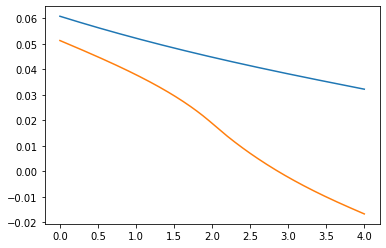

In [12]:
plt.plot(y_grid, ϕ_low)
plt.plot(y_grid, ϕ_high)
# plt.plot(y_grid, v_dict[2])

In [13]:
bd = (ϕ_low[numy_bar]+ϕ_high[numy_bar])/2
bd

0.03178853770929496

In [14]:
dmg_weight = np.array([0.5, 0.5])
y_grid_cap = np.linspace(0,2,100)
dΛ = γ1 + γ2*y_grid_cap + np.average(γ2p, weights=dmg_weight)*(y_grid_cap - γbar)*(y_grid_cap > ȳ)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid_cap
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
ems_old = ems
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    ems[ems<=0] = 1e-15
    ems = ems*0.5 + ems_old*0.5
    A = -δ*np.ones(y_grid_cap.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid_cap.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ,  ϵ, (True,bd))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    ems_old = ems
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0014889572346544594,	 ft error: 0.10809512569765033
episode: 2,	 ode error: 0.011306551294115123,	 ft error: 0.010273852205091737
episode: 3,	 ode error: 0.004845264882540391,	 ft error: 0.004786846677040027
episode: 4,	 ode error: 0.002023287061359712,	 ft error: 0.005721278420030158
episode: 5,	 ode error: 0.0037867882307878234,	 ft error: 0.0020795010408778164
episode: 6,	 ode error: 0.004296874279911048,	 ft error: 0.0011603492017950995
episode: 7,	 ode error: 0.002891315648939169,	 ft error: 0.010265086256344163
episode: 8,	 ode error: 0.002759996968614138,	 ft error: 0.0040587248427558795
episode: 9,	 ode error: 0.0017042988412744769,	 ft error: 0.003465610115896394
episode: 10,	 ode error: 0.0021274909297570423,	 ft error: 0.001648029532671723
episode: 11,	 ode error: 0.0018905980199165483,	 ft error: 0.0016237893353301875
episode: 12,	 ode error: 0.0022198361233455415,	 ft error: 0.001801478783456922
episode: 13,	 ode error: 0.0027693652320687767,	 ft 

episode: 161,	 ode error: 0.0006438638330340058,	 ft error: 0.0006516317295564983
episode: 162,	 ode error: 0.0006400363037706648,	 ft error: 0.0006479500012262126
episode: 163,	 ode error: 0.0006365011798450527,	 ft error: 0.0006443876668141049
episode: 164,	 ode error: 0.0006337119844263361,	 ft error: 0.0006408574085886345
episode: 165,	 ode error: 0.0006359807059237516,	 ft error: 0.0006375223285261477
episode: 166,	 ode error: 0.0006351304927093735,	 ft error: 0.000633840569299234
episode: 167,	 ode error: 0.0006319577759638727,	 ft error: 0.0006291092786877654
episode: 168,	 ode error: 0.0006272343503975923,	 ft error: 0.0006233846993699879
episode: 169,	 ode error: 0.0006215577197715683,	 ft error: 0.0006171026521642475
episode: 170,	 ode error: 0.0006153247130365914,	 ft error: 0.0006105200824197318
episode: 171,	 ode error: 0.000608785332507093,	 ft error: 0.0006037930426724264
episode: 172,	 ode error: 0.0006020955082060251,	 ft error: 0.0005970159304035985
episode: 173,	 ode

episode: 324,	 ode error: 0.00011890502222898719,	 ft error: 0.0001178602051514488
episode: 325,	 ode error: 0.00011752575484111881,	 ft error: 0.00011648676376536475
episode: 326,	 ode error: 0.00011615823588753747,	 ft error: 0.00011512475038307861
episode: 327,	 ode error: 0.00011480236562518248,	 ft error: 0.00011377406105984404
episode: 328,	 ode error: 0.00011345804544479049,	 ft error: 0.0001124345997437215
episode: 329,	 ode error: 0.00011212511472854147,	 ft error: 0.00011112728467152963
episode: 330,	 ode error: 0.00011080288020246215,	 ft error: 0.00010981272397359484
episode: 331,	 ode error: 0.0001094921308693557,	 ft error: 0.00010850950292215038
episode: 332,	 ode error: 0.00010819268234253784,	 ft error: 0.00010721746420039777
episode: 333,	 ode error: 0.00010690435576283781,	 ft error: 0.00010594624856317496
episode: 334,	 ode error: 0.00010562697525808452,	 ft error: 0.00010467118725238089
episode: 335,	 ode error: 0.00010436071358764585,	 ft error: 0.0001034094827463

episode: 518,	 ode error: 2.577661595039196e-06,	 ft error: 1.528912730077344e-06
episode: 519,	 ode error: 2.5713404541747665e-06,	 ft error: 1.4613796382502895e-06
episode: 520,	 ode error: 2.565110493193859e-06,	 ft error: 1.3962020275343212e-06
episode: 521,	 ode error: 2.559076624057753e-06,	 ft error: 1.3333197738246705e-06
episode: 522,	 ode error: 2.5533334199273833e-06,	 ft error: 1.2726734744996269e-06
episode: 523,	 ode error: 2.54796397258989e-06,	 ft error: 1.2142044782809114e-06
episode: 524,	 ode error: 2.543038877737434e-06,	 ft error: 1.1578549158110705e-06
episode: 525,	 ode error: 2.5386154377524724e-06,	 ft error: 1.1035677245409734e-06
episode: 526,	 ode error: 2.534737527124767e-06,	 ft error: 1.0512866751901293e-06
episode: 527,	 ode error: 2.531435639470522e-06,	 ft error: 1.0009563951076292e-06
episode: 528,	 ode error: 2.5287272378798475e-06,	 ft error: 9.525223901065324e-07
episode: 529,	 ode error: 2.526617351431351e-06,	 ft error: 9.059310618573606e-07
epis

episode: 716,	 ode error: 2.5519471058269754e-06,	 ft error: 1.3372161618748398e-08
episode: 717,	 ode error: 2.5519455673336843e-06,	 ft error: 1.3293413198926334e-08
episode: 718,	 ode error: 2.5519447639388987e-06,	 ft error: 1.323272937984547e-08
episode: 719,	 ode error: 2.5519446781991067e-06,	 ft error: 1.3154615799426672e-08
episode: 720,	 ode error: 2.551945246256535e-06,	 ft error: 1.3091973385022845e-08
episode: 721,	 ode error: 2.5519464973363954e-06,	 ft error: 1.3021622946585154e-08
episode: 722,	 ode error: 2.5519483002532607e-06,	 ft error: 1.2950103882765815e-08
episode: 723,	 ode error: 2.551950622327651e-06,	 ft error: 1.2887150073933226e-08
episode: 724,	 ode error: 2.551953410309302e-06,	 ft error: 1.2807157186619142e-08
episode: 725,	 ode error: 2.5519565779864688e-06,	 ft error: 1.2710431272304017e-08
episode: 726,	 ode error: 2.551960078363974e-06,	 ft error: 1.2597287472419321e-08
episode: 727,	 ode error: 2.5519638093316572e-06,	 ft error: 1.2468053256498024e-

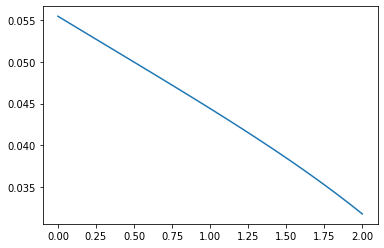

In [15]:
ϕ_pre = ϕ
plt.plot(y_grid_cap, ϕ_pre)

In [16]:
ϕ_pre[-1]

0.0317885377092871

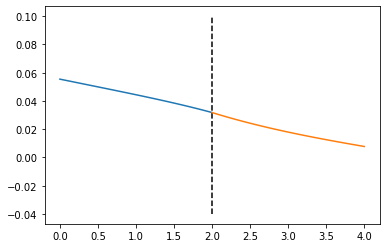

In [17]:
plt.plot(y_grid_cap,ϕ_pre)
plt.plot(y_grid[numy_bar:], (ϕ_low[numy_bar:] + ϕ_high[numy_bar:])/2)
plt.vlines(2, ymin=-.04, ymax=.1, color="black", linestyle="dashed")

# Jump of damage
$$
0 = -\delta \phi + \frac{\partial \phi }{\partial y} \mu_2 e + \delta\eta\log (e) + (\eta-1)(\tau_1 + \tau_2 y) \mu_2 e +\frac{\exp\{\rho( y - \bar y)\}}{1 - \exp\{\rho( y -\bar y)\}} \cdot \left(\sum_{j=2}^{n}\pi_j\tilde \phi(y) - \phi(y)\right) \quad y \in [0, \bar y)
$$
where
$$
    e = -\frac{ \delta\eta}{\frac{\partial \phi }{\partial y} \mu_2 +  (\eta-1)(\tau_1 + \tau_2 y) \mu_2 }
$$

$$
\phi(\bar y) = \sum_{j=2}^{n} \pi_j \phi_j(\bar y)
$$

$$
\text{Jump intensity} = \frac{1}{\sqrt{2\pi}\sigma}\exp\{ - \frac{(y - \bar  y)^2}{2\sigma^2}\}
$$

Try
$$
\sigma = \bar y/10, \quad \bar y/50, \quad \bar y/100
$$

In [18]:
y_dense = np.arange(0,2,1/20000)
def get_intensity(y_grid, σ, γbar=2):
    temp = 1/(np.sqrt(np.pi*2)*σ)*np.exp(-(y_grid - γbar)**2/(2*σ**2))
#     temp *= v_bar - v_new
    return temp

In [20]:
dmg_weight = np.array([0.5, 0.5])
y_grid_cap = y_grid[:numy_bar+1]
dΛ = γ1 + γ2*y_grid_cap + np.average(γ2p, weights=dmg_weight)*(y_grid_cap - γbar)*(y_grid_cap>γbar)


ϕ_average = np.average([ϕ_low[:numy_bar+1], ϕ_high[:numy_bar+1]], axis=0, weights=dmg_weight)
tol = 1e-8


ϕ = - δ*η*y_grid_cap
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
episode = 0

ϕ_dict = dict()
for σ in [γbar/10, γbar/50, γbar/100]:
    ϕ = - δ*η*y_grid_cap
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    ems_old = ems
    episode = 0
    ϵ = .3
    lhs_error = 1
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
        ems[ems<=0] = 1e-15
        ems = 0.5*ems + 0.5*ems_old
        A = -δ*np.ones(y_grid_cap.shape) - get_intensity(y_grid_cap, σ)
        By = μ*ems
        Cyy = np.zeros(y_grid_cap.shape)
        D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems + get_intensity(y_grid_cap, σ)*ϕ_average
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, bd))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    ϕ_dict[σ] = ϕ

episode: 1,	 ode error: 0.06416487605535236,	 ft error: 0.1080951256976543
episode: 2,	 ode error: 0.07115819903858542,	 ft error: 0.025834279459237032
episode: 3,	 ode error: 0.06550723193691527,	 ft error: 0.016990136606134118
episode: 4,	 ode error: 0.06377012906195342,	 ft error: 0.012278383953536361
episode: 5,	 ode error: 0.06375221369483249,	 ft error: 0.009469459037430156
episode: 6,	 ode error: 0.06379963347011287,	 ft error: 0.007597795190695927
episode: 7,	 ode error: 0.0638645883869333,	 ft error: 0.006247508530324806
episode: 8,	 ode error: 0.0639026143260904,	 ft error: 0.005222921115787029
episode: 9,	 ode error: 0.0638829910914035,	 ft error: 0.004398467800337906
episode: 10,	 ode error: 0.06383969986982635,	 ft error: 0.0037208520541377283
episode: 11,	 ode error: 0.0638005645177623,	 ft error: 0.0031483346833193855
episode: 12,	 ode error: 0.06377308832239782,	 ft error: 0.005508503397115393
episode: 13,	 ode error: 0.06375531562781572,	 ft error: 0.003740124105895675

episode: 108,	 ode error: 0.06372460498212586,	 ft error: 0.0011911423115297526
episode: 109,	 ode error: 0.06372497283368546,	 ft error: 0.0010935623368461707
episode: 110,	 ode error: 0.06372534348644142,	 ft error: 0.006002448874341075
episode: 111,	 ode error: 0.10708994824789658,	 ft error: 0.0015250002062287132
episode: 112,	 ode error: 0.06372511832093757,	 ft error: 0.0013295213601801268
episode: 113,	 ode error: 0.06372517946367527,	 ft error: 0.0012781593559810928
episode: 114,	 ode error: 0.06372521267293028,	 ft error: 0.001255222447349135
episode: 115,	 ode error: 0.0637252306978283,	 ft error: 0.0018240161879030242
episode: 116,	 ode error: 0.06372524047298543,	 ft error: 0.0012555676857410603
episode: 117,	 ode error: 0.06372524577051183,	 ft error: 0.0012333718470006888
episode: 118,	 ode error: 0.06372524863856892,	 ft error: 0.001212385972857305
episode: 119,	 ode error: 0.06372524300465483,	 ft error: 0.0011941991494354247
episode: 120,	 ode error: 0.0637253754481581

episode: 373,	 ode error: 0.06372572516326798,	 ft error: 1.3946763020971272e-05
episode: 374,	 ode error: 0.06372572515963751,	 ft error: 1.3474655920289735e-05
episode: 375,	 ode error: 0.06372572515580578,	 ft error: 1.3013432776839048e-05
episode: 376,	 ode error: 0.06372572515178841,	 ft error: 1.2563009204486868e-05
episode: 377,	 ode error: 0.063725725147601,	 ft error: 1.2123298072259463e-05
episode: 378,	 ode error: 0.06372572514325918,	 ft error: 1.1694209446864539e-05
episode: 379,	 ode error: 0.06372572513877851,	 ft error: 1.1275650541782886e-05
episode: 380,	 ode error: 0.06372572513417446,	 ft error: 1.0867525672882591e-05
episode: 381,	 ode error: 0.06372572512946235,	 ft error: 1.0469736221064656e-05
episode: 382,	 ode error: 0.06372572512465731,	 ft error: 1.0082180602171328e-05
episode: 383,	 ode error: 0.06372572511977419,	 ft error: 9.704754245174845e-06
episode: 384,	 ode error: 0.06372572511482762,	 ft error: 9.337349576958125e-06
episode: 385,	 ode error: 0.0637

episode: 35,	 ode error: 0.31704351919758267,	 ft error: 0.0016784275801829361
episode: 36,	 ode error: 0.3170530414459435,	 ft error: 0.0015594782053612519
episode: 37,	 ode error: 0.31706656435173614,	 ft error: 0.0026022136540983522
episode: 38,	 ode error: 0.317084511913169,	 ft error: 0.0015448619501465372
episode: 39,	 ode error: 0.3171060929927402,	 ft error: 0.002202397443223711
episode: 40,	 ode error: 0.31713070949624245,	 ft error: 0.0015507796729223127
episode: 41,	 ode error: 0.31715909006588855,	 ft error: 0.0020899927230400655
episode: 42,	 ode error: 0.31719084645954115,	 ft error: 0.002001568917020808
episode: 43,	 ode error: 0.3172287844336211,	 ft error: 0.0034875233526778715
episode: 44,	 ode error: 0.3172659365897022,	 ft error: 0.0018400616987312875
episode: 45,	 ode error: 0.31735507996105494,	 ft error: 0.00199313446167865
episode: 46,	 ode error: 0.31730135145973964,	 ft error: 0.008701217036480314
episode: 47,	 ode error: 0.31718695857621476,	 ft error: 0.0062

episode: 196,	 ode error: 0.3170240780305995,	 ft error: 0.0004085848212775911
episode: 197,	 ode error: 0.31702407803057875,	 ft error: 0.00040484816369541765
episode: 198,	 ode error: 0.317024078030559,	 ft error: 0.0004011156933275926
episode: 199,	 ode error: 0.31702407803054056,	 ft error: 0.0003973896460853869
episode: 200,	 ode error: 0.3170240780305256,	 ft error: 0.00039367218368923285
episode: 201,	 ode error: 0.31702407803051214,	 ft error: 0.00038996537013539595
episode: 202,	 ode error: 0.3170240780305013,	 ft error: 0.0003862711554971967
episode: 203,	 ode error: 0.3170240780304925,	 ft error: 0.000382591364795649
episode: 204,	 ode error: 0.31702407803048727,	 ft error: 0.0003789276916198644
episode: 205,	 ode error: 0.3170240780304839,	 ft error: 0.0003752816950542091
episode: 206,	 ode error: 0.3170240780304835,	 ft error: 0.00037165479937026347
episode: 207,	 ode error: 0.3170240780304842,	 ft error: 0.0003680482960446522
episode: 208,	 ode error: 0.317024078030487,	 

episode: 356,	 ode error: 0.31702407803048877,	 ft error: 6.61857332955503e-05
episode: 357,	 ode error: 0.31702407803048827,	 ft error: 6.520715469013338e-05
episode: 358,	 ode error: 0.31702407803048893,	 ft error: 6.423761024524263e-05
episode: 359,	 ode error: 0.31702407803048976,	 ft error: 6.327705009167203e-05
episode: 360,	 ode error: 0.31702407803048943,	 ft error: 6.232542522123982e-05
episode: 361,	 ode error: 0.3170240780304877,	 ft error: 6.138268747705086e-05
episode: 362,	 ode error: 0.31702407803048727,	 ft error: 6.044878954288013e-05
episode: 363,	 ode error: 0.3170240780304885,	 ft error: 5.9523684933759e-05
episode: 364,	 ode error: 0.31702407803048965,	 ft error: 5.860732798556682e-05
episode: 365,	 ode error: 0.3170240780304878,	 ft error: 5.769967384494645e-05
episode: 366,	 ode error: 0.3170240780304862,	 ft error: 5.680067845903469e-05
episode: 367,	 ode error: 0.3170240780304885,	 ft error: 5.591029856500766e-05
episode: 368,	 ode error: 0.3170240780304895,	 f

episode: 517,	 ode error: 0.31702407803048793,	 ft error: 4.925514839743128e-07
episode: 518,	 ode error: 0.3170240780304881,	 ft error: 4.656593577863818e-07
episode: 519,	 ode error: 0.3170240780304876,	 ft error: 4.4009373027786847e-07
episode: 520,	 ode error: 0.3170240780304894,	 ft error: 4.158018808199845e-07
episode: 521,	 ode error: 0.3170240780304882,	 ft error: 3.927324305115961e-07
episode: 522,	 ode error: 0.31702407803048854,	 ft error: 3.708353464813389e-07
episode: 523,	 ode error: 0.31702407803048765,	 ft error: 3.500619439461561e-07
episode: 524,	 ode error: 0.31702407803048827,	 ft error: 3.3036488660450247e-07
episode: 525,	 ode error: 0.317024078030489,	 ft error: 3.1169818450841696e-07
episode: 526,	 ode error: 0.3170240780304878,	 ft error: 2.940171898770568e-07
episode: 527,	 ode error: 0.3170240780304889,	 ft error: 2.7727859103673e-07
episode: 528,	 ode error: 0.3170240780304882,	 ft error: 2.614404052044458e-07
episode: 529,	 ode error: 0.3170240780304885,	 f

episode: 40,	 ode error: 0.634494205149042,	 ft error: 0.002517313871616955
episode: 41,	 ode error: 0.6345416955665796,	 ft error: 0.00201719386512169
episode: 42,	 ode error: 0.6345974503815502,	 ft error: 0.0016192217717798016
episode: 43,	 ode error: 0.6346649673662826,	 ft error: 0.005707220930951547
episode: 44,	 ode error: 0.6347505920148714,	 ft error: 0.002702781699815797
episode: 45,	 ode error: 0.6348678551493547,	 ft error: 0.0013788626751852207
episode: 46,	 ode error: 0.6350558272238707,	 ft error: 0.002376249111385945
episode: 47,	 ode error: 0.6356183304357065,	 ft error: 0.0017488692244247046
episode: 48,	 ode error: 0.6359619362719519,	 ft error: 0.00146211318038243
episode: 49,	 ode error: 0.6357846147882502,	 ft error: 0.0014422427825998923
episode: 50,	 ode error: 0.6354659385997568,	 ft error: 0.0015241095998838375
episode: 51,	 ode error: 0.6351361407853534,	 ft error: 0.003058245128534735
episode: 52,	 ode error: 0.634830560278474,	 ft error: 0.00144309152871978

episode: 157,	 ode error: 0.6340684429804769,	 ft error: 0.0006116800954240192
episode: 158,	 ode error: 0.6340684429799902,	 ft error: 0.0006043140393703166
episode: 159,	 ode error: 0.6340684429797657,	 ft error: 0.0005971259219234258
episode: 160,	 ode error: 0.6340684429794184,	 ft error: 0.0005901056713646565
episode: 161,	 ode error: 0.6340684429789822,	 ft error: 0.0005832445075597502
episode: 162,	 ode error: 0.6340684429787071,	 ft error: 0.0005765341689759988
episode: 163,	 ode error: 0.6340684429786051,	 ft error: 0.0005699670353658676
episode: 164,	 ode error: 0.6340684429786734,	 ft error: 0.0005635359435883965
episode: 165,	 ode error: 0.6340684429786153,	 ft error: 0.0005572349376708567
episode: 166,	 ode error: 0.6340684429789804,	 ft error: 0.0005510567136665414
episode: 167,	 ode error: 0.6340684429786498,	 ft error: 0.0005449962914324397
episode: 168,	 ode error: 0.6340684429785375,	 ft error: 0.0005390484460302224
episode: 169,	 ode error: 0.634068442978499,	 ft err

episode: 327,	 ode error: 0.6340684429805737,	 ft error: 0.00010409645478303328
episode: 328,	 ode error: 0.6340684429805163,	 ft error: 0.00010284227689965712
episode: 329,	 ode error: 0.6340684429806988,	 ft error: 0.00010159809258616463
episode: 330,	 ode error: 0.6340684429808597,	 ft error: 0.00010036405837861306
episode: 331,	 ode error: 0.6340684429806663,	 ft error: 9.914010428923685e-05
episode: 332,	 ode error: 0.6340684429807092,	 ft error: 9.792610329309448e-05
episode: 333,	 ode error: 0.6340684429809493,	 ft error: 9.672202860529222e-05
episode: 334,	 ode error: 0.6340684429810064,	 ft error: 9.552779980250004e-05
episode: 335,	 ode error: 0.6340684429810519,	 ft error: 9.434334767214245e-05
episode: 336,	 ode error: 0.6340684429810266,	 ft error: 9.31686096884247e-05
episode: 337,	 ode error: 0.6340684429809831,	 ft error: 9.200351808439737e-05
episode: 338,	 ode error: 0.6340684429810044,	 ft error: 9.084800755121414e-05
episode: 339,	 ode error: 0.6340684429808552,	 ft

episode: 497,	 ode error: 0.6340684429793906,	 ft error: 2.324512466284993e-06
episode: 498,	 ode error: 0.6340684429795843,	 ft error: 2.2279348058096282e-06
episode: 499,	 ode error: 0.6340684429795025,	 ft error: 2.1345885828592355e-06
episode: 500,	 ode error: 0.6340684429794453,	 ft error: 2.0444031685838233e-06
episode: 501,	 ode error: 0.6340684429794782,	 ft error: 1.9573080202682043e-06
episode: 502,	 ode error: 0.634068442979598,	 ft error: 1.8732327324253821e-06
episode: 503,	 ode error: 0.6340684429793975,	 ft error: 1.7921070871960525e-06
episode: 504,	 ode error: 0.6340684429794853,	 ft error: 1.7138611044011562e-06
episode: 505,	 ode error: 0.6340684429794716,	 ft error: 1.6384250909005453e-06
episode: 506,	 ode error: 0.6340684429793754,	 ft error: 1.5657296899053894e-06
episode: 507,	 ode error: 0.6340684429793325,	 ft error: 1.4957059286715055e-06
episode: 508,	 ode error: 0.6340684429794157,	 ft error: 1.4282852659613932e-06
episode: 509,	 ode error: 0.63406844297939

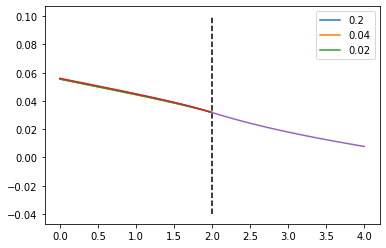

In [22]:
for σ in [γbar/10, γbar/50, γbar/100]:
    plt.plot(y_grid_cap,ϕ_dict[σ], label=σ)
plt.legend()
plt.plot(y_grid_cap, ϕ_average)
plt.plot(y_grid[numy_bar:], (ϕ_low[numy_bar:] + ϕ_high[numy_bar:])/2)
plt.vlines(2, ymin=-.04, ymax=.1, color="black", linestyle="dashed")

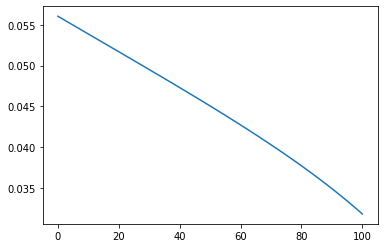

In [23]:
plt.plot(ϕ_average)

# new setup
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
                           &  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

$$
\begin{aligned}
0 = \min_h & - \delta \psi(z_2) - \delta \eta \log(z_2) + \frac{\xi_m}{2} h'h\\
 & + \frac{d\psi(z_2)}{dz_2}\left[ - \rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h \right] + \frac{z_2|\sigma_2|^2}{2}\frac{d^2\psi(z_2)}{dz_2^2}
\end{aligned}
$$

$$
    h^* = -\frac{\frac{d\psi(z_2)}{dz_2} \sqrt{z_2}\sigma_2}{\xi_m}
$$

In [49]:
# z2 grid
ρ = 0.9
ξₘ = 1/10000
σz = 0.42/1000
σ2 = np.sqrt(2*ρ*σz**2/μ)
num_z = 100
z2_min = μ - 4*σz
z2_max = μ + 4*σz
z2_grid = np.linspace(z2_min, z2_max, num_z)
hz = z2_grid[1] - z2_grid[0]
# ODE for z_2
episode = 0
ϵ = .3
tol = 1e-8
lhs_error = 1
ψ = δ*z2_grid
h_star = -δ*np.sqrt(z2_grid)*σ2/ξₘ
while lhs_error > tol:
    ψ_old = ψ.copy()
    dψdz = derivative_1d(ψ, 1, hz)
    dψdzz = derivative_1d(ψ, 2, hz)
    h_star = - dψdz*np.sqrt(z2_grid)*σz/ξₘ*0.5 + h_star*0.5
    A = -δ*np.ones(z2_grid.shape)
    B = - ρ*(z2_grid - μ) + np.sqrt(z2_grid)*σ2*h_star
    C = z2_grid*σ2**2/2
    D = - δ*η*np.log(z2_grid) + 1/2*ξₘ*h_star**2
    ψ_new = solve_ode(A, B, C, D, z2_grid, ψ, ϵ, (False, 0))
    rhs = -δ*ψ_new + B*dψdz + C*dψdzz + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ψ_new - ψ_old)/ϵ))
    ψ = ψ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0027668991104571597,	 ft error: 0.002469436644212557
episode: 2,	 ode error: 0.002468283201042793,	 ft error: 0.002310055100419424
episode: 3,	 ode error: 0.0023109256602490656,	 ft error: 0.002213258216324765
episode: 4,	 ode error: 0.0022150358430490244,	 ft error: 0.0021485238021513938
episode: 5,	 ode error: 0.0021508159635263355,	 ft error: 0.002102374935056964
episode: 6,	 ode error: 0.0021049472646561245,	 ft error: 0.0020678321482357
episode: 7,	 ode error: 0.0020706187116423603,	 ft error: 0.0020410233727415506
episode: 8,	 ode error: 0.002043993115122162,	 ft error: 0.0020196465192638046
episode: 9,	 ode error: 0.0020227173295683043,	 ft error: 0.0020020775538548046
episode: 10,	 ode error: 0.002005264781392786,	 ft error: 0.001987420384131497
episode: 11,	 ode error: 0.0019906086402082662,	 ft error: 0.0019747786753830654
episode: 12,	 ode error: 0.0019780263233344945,	 ft error: 0.0019637342165603386
episode: 13,	 ode error: 0.001967013474801532,	 

episode: 132,	 ode error: 0.0013649065158733245,	 ft error: 0.0013588737474329315
episode: 133,	 ode error: 0.0013605799967490902,	 ft error: 0.0013551611814133688
episode: 134,	 ode error: 0.001357100399951493,	 ft error: 0.0013508438826198566
episode: 135,	 ode error: 0.0013526277940263533,	 ft error: 0.0013462659168711941
episode: 136,	 ode error: 0.0013476648231862361,	 ft error: 0.001342123953684965
episode: 137,	 ode error: 0.0013438535761413494,	 ft error: 0.0013380686113219817
episode: 138,	 ode error: 0.0013404503472295875,	 ft error: 0.001334126356328467
episode: 139,	 ode error: 0.0013366643824262942,	 ft error: 0.001330784855094978
episode: 140,	 ode error: 0.0013322719122464812,	 ft error: 0.0013258755908164555
episode: 141,	 ode error: 0.001328805439364083,	 ft error: 0.0013229932890312934
episode: 142,	 ode error: 0.00132470568026758,	 ft error: 0.0013179691739466834
episode: 143,	 ode error: 0.0013216192111977414,	 ft error: 0.0013142362763601811
episode: 144,	 ode erro

episode: 283,	 ode error: 0.0008689088345849464,	 ft error: 0.000865033517541645
episode: 284,	 ode error: 0.0008666023636696912,	 ft error: 0.000862733262077392
episode: 285,	 ode error: 0.0008643926732361536,	 ft error: 0.0008592690774166893
episode: 286,	 ode error: 0.0008619204882925177,	 ft error: 0.0008567434786245498
episode: 287,	 ode error: 0.0008594318478744682,	 ft error: 0.0008541663250983638
episode: 288,	 ode error: 0.0008566317922723495,	 ft error: 0.0008512311073955355
episode: 289,	 ode error: 0.0008541448819963818,	 ft error: 0.0008488006136674979
episode: 290,	 ode error: 0.0008514839328806297,	 ft error: 0.0008480148657252311
episode: 291,	 ode error: 0.0008525582078481979,	 ft error: 0.0008452269396879801
episode: 292,	 ode error: 0.0008463900657266375,	 ft error: 0.0008424281463795721
episode: 293,	 ode error: 0.0008449994049002979,	 ft error: 0.0008389068345412514
episode: 294,	 ode error: 0.00084190240476129,	 ft error: 0.0008368851503925042
episode: 295,	 ode e

episode: 445,	 ode error: 0.0005400797863328386,	 ft error: 0.0005316291770379733
episode: 446,	 ode error: 0.0005384900208899297,	 ft error: 0.0005300381596520798
episode: 447,	 ode error: 0.0005369044328523119,	 ft error: 0.0005284534752396838
episode: 448,	 ode error: 0.0005353241404519489,	 ft error: 0.0005268720032509482
episode: 449,	 ode error: 0.0005337480732674302,	 ft error: 0.0005252967674484096
episode: 450,	 ode error: 0.0005321771849223582,	 ft error: 0.0005237247794780594
episode: 451,	 ode error: 0.000530610520494867,	 ft error: 0.0005221589360894046
episode: 452,	 ode error: 0.0005290490063895234,	 ft error: 0.0005205963733364202
episode: 453,	 ode error: 0.0005274917403433976,	 ft error: 0.0005190398674072746
episode: 454,	 ode error: 0.000525939542003353,	 ft error: 0.0005174866684024004
episode: 455,	 ode error: 0.0005243916262833096,	 ft error: 0.0005159394455256372
episode: 456,	 ode error: 0.0005228486523093533,	 ft error: 0.0005143955512523779
episode: 457,	 ode

episode: 610,	 ode error: 0.00033276391282593097,	 ft error: 0.0003243047037615465
episode: 611,	 ode error: 0.00033179392784678675,	 ft error: 0.0003233346997796871
episode: 612,	 ode error: 0.0003308268699739863,	 ft error: 0.0003223675977503948
episode: 613,	 ode error: 0.00032986266388348334,	 ft error: 0.0003214033887133372
episode: 614,	 ode error: 0.0003289013858004536,	 ft error: 0.0003204420630454711
episode: 615,	 ode error: 0.00032794296004524525,	 ft error: 0.0003194836115369415
episode: 616,	 ode error: 0.0003269873866991154,	 ft error: 0.0003185280289016065
episode: 617,	 ode error: 0.0003260346765254713,	 ft error: 0.00031757530369482445
episode: 618,	 ode error: 0.000325084834349885,	 ft error: 0.0003166254286818271
episode: 619,	 ode error: 0.0003241378242907799,	 ft error: 0.0003156783935076568
episode: 620,	 ode error: 0.00032319365857883496,	 ft error: 0.0003147341921025393
episode: 621,	 ode error: 0.00032225230811186055,	 ft error: 0.00031379281403222847
episode: 

episode: 776,	 ode error: 0.00020570393306615625,	 ft error: 0.00019724159679157527
episode: 777,	 ode error: 0.00020511400034686485,	 ft error: 0.0001966516416114043
episode: 778,	 ode error: 0.00020452580751922325,	 ft error: 0.0001960634522863806
episode: 779,	 ode error: 0.00020393938380678061,	 ft error: 0.00019547702081892013
episode: 780,	 ode error: 0.00020335475223922967,	 ft error: 0.00019489234400168107
episode: 781,	 ode error: 0.0002027718324192373,	 ft error: 0.00019430941662447929
episode: 782,	 ode error: 0.00020219064288320293,	 ft error: 0.00019372823219713603
episode: 783,	 ode error: 0.0002016112040515107,	 ft error: 0.0001931487866752013
episode: 784,	 ode error: 0.00020103350939152612,	 ft error: 0.00019257107352630792
episode: 785,	 ode error: 0.00020045755400980984,	 ft error: 0.00019199508838801949
episode: 786,	 ode error: 0.00019988331380043798,	 ft error: 0.00019142082654947473
episode: 787,	 ode error: 0.00019931076726917535,	 ft error: 0.000190848281668987

episode: 940,	 ode error: 0.00012914690877528323,	 ft error: 0.00012068287044077661
episode: 941,	 ode error: 0.00012878593637795214,	 ft error: 0.0001203219048403111
episode: 942,	 ode error: 0.0001284260562712709,	 ft error: 0.00011996201932096273
episode: 943,	 ode error: 0.00012806728465625055,	 ft error: 0.00011960320826278256
episode: 944,	 ode error: 0.00012770952914598651,	 ft error: 0.00011924547369461062
episode: 945,	 ode error: 0.0001273528605279942,	 ft error: 0.00011888880610368599
episode: 946,	 ode error: 0.00012699727078678818,	 ft error: 0.00011853320882169542
episode: 947,	 ode error: 0.00012664273261099525,	 ft error: 0.00011817867034543314
episode: 948,	 ode error: 0.0001262892972924202,	 ft error: 0.00011782519676845071
episode: 949,	 ode error: 0.00012593687413319844,	 ft error: 0.00011747277804905847
episode: 950,	 ode error: 0.00012558553076401618,	 ft error: 0.00011712141403672864
episode: 951,	 ode error: 0.00012523520698921767,	 ft error: 0.00011677110025013

episode: 1105,	 ode error: 8.209092929884875e-05,	 ft error: 7.365464210336756e-05
episode: 1106,	 ode error: 8.186491722081304e-05,	 ft error: 7.343351797158468e-05
episode: 1107,	 ode error: 8.164987833994878e-05,	 ft error: 7.321052974138913e-05
episode: 1108,	 ode error: 8.142598799977356e-05,	 ft error: 7.299172330601142e-05
episode: 1109,	 ode error: 8.121185692867199e-05,	 ft error: 7.276973944101799e-05
episode: 1110,	 ode error: 8.098992034290828e-05,	 ft error: 7.255280827224894e-05
episode: 1111,	 ode error: 8.077673097362631e-05,	 ft error: 7.233210145340951e-05
episode: 1112,	 ode error: 8.05565930192501e-05,	 ft error: 7.211676834863642e-05
episode: 1113,	 ode error: 8.034433234176694e-05,	 ft error: 7.18974924945881e-05
episode: 1114,	 ode error: 8.012595890612498e-05,	 ft error: 7.168358680984903e-05
episode: 1115,	 ode error: 7.991462809721372e-05,	 ft error: 7.146581666848488e-05
episode: 1116,	 ode error: 7.969793472977112e-05,	 ft error: 7.12532320644906e-05
episode

episode: 1269,	 ode error: 5.3507663923922514e-05,	 ft error: 4.504689063378198e-05
episode: 1270,	 ode error: 5.337351312334677e-05,	 ft error: 4.491206795326219e-05
episode: 1271,	 ode error: 5.323972555819627e-05,	 ft error: 4.4776797539595556e-05
episode: 1272,	 ode error: 5.310610123583116e-05,	 ft error: 4.464233609613455e-05
episode: 1273,	 ode error: 5.297278596675119e-05,	 ft error: 4.4508967027475275e-05
episode: 1274,	 ode error: 5.283982966580486e-05,	 ft error: 4.437558003213734e-05
episode: 1275,	 ode error: 5.2707253669254366e-05,	 ft error: 4.4242866928205046e-05
episode: 1276,	 ode error: 5.257502980635402e-05,	 ft error: 4.4110396943501204e-05
episode: 1277,	 ode error: 5.244318354754576e-05,	 ft error: 4.3978548563416986e-05
episode: 1278,	 ode error: 5.231176885500742e-05,	 ft error: 4.384664505187782e-05
episode: 1279,	 ode error: 5.218066409238284e-05,	 ft error: 4.371562404468603e-05
episode: 1280,	 ode error: 5.2049971474576106e-05,	 ft error: 4.35859149600093e-

episode: 1431,	 ode error: 3.61798138942453e-05,	 ft error: 2.773304346901743e-05
episode: 1432,	 ode error: 3.609887399320423e-05,	 ft error: 2.7658411281920408e-05
episode: 1433,	 ode error: 3.601816075308583e-05,	 ft error: 2.8118919614591085e-05
episode: 1434,	 ode error: 3.582551997086646e-05,	 ft error: 2.7804584920391544e-05
episode: 1435,	 ode error: 3.577715124937551e-05,	 ft error: 2.7448486437375852e-05
episode: 1436,	 ode error: 3.571070153579928e-05,	 ft error: 2.7407427413602324e-05
episode: 1437,	 ode error: 3.565126749215347e-05,	 ft error: 2.7255470214741322e-05
episode: 1438,	 ode error: 3.5577068715284075e-05,	 ft error: 2.7194063007644303e-05
episode: 1439,	 ode error: 3.550670327207863e-05,	 ft error: 2.7079948632842875e-05
episode: 1440,	 ode error: 3.542840367690668e-05,	 ft error: 2.7028540249736853e-05
episode: 1441,	 ode error: 3.535442626880023e-05,	 ft error: 2.691841039348386e-05
episode: 1442,	 ode error: 3.527607118723134e-05,	 ft error: 2.685724930136709

episode: 1599,	 ode error: 2.5267905085144026e-05,	 ft error: 1.6822291002046207e-05
episode: 1600,	 ode error: 2.5205578196700086e-05,	 ft error: 1.6725065784724734e-05
episode: 1601,	 ode error: 2.5154689424009523e-05,	 ft error: 1.6708604351027095e-05
episode: 1602,	 ode error: 2.5095888443807174e-05,	 ft error: 1.6630172188503156e-05
episode: 1603,	 ode error: 2.504680708400415e-05,	 ft error: 1.6599712145496753e-05
episode: 1604,	 ode error: 2.49904417761594e-05,	 ft error: 1.65329019056563e-05
episode: 1605,	 ode error: 2.4942501985131e-05,	 ft error: 1.649417796197502e-05
episode: 1606,	 ode error: 2.4887930221720528e-05,	 ft error: 1.643458229857083e-05
episode: 1607,	 ode error: 2.4840721120543635e-05,	 ft error: 1.6390973768913113e-05
episode: 1608,	 ode error: 2.478749735422862e-05,	 ft error: 1.6335998516229615e-05
episode: 1609,	 ode error: 2.4740785657277392e-05,	 ft error: 1.628953269254089e-05
episode: 1610,	 ode error: 2.4688612723402104e-05,	 ft error: 1.6237531687094

episode: 1763,	 ode error: 1.87235918981646e-05,	 ft error: 1.0257373158536106e-05
episode: 1764,	 ode error: 1.8692909641022937e-05,	 ft error: 1.0226698547259144e-05
episode: 1765,	 ode error: 1.8662300675282217e-05,	 ft error: 1.0196104815266931e-05
episode: 1766,	 ode error: 1.86318196010156e-05,	 ft error: 1.0165613643087212e-05
episode: 1767,	 ode error: 1.860142213914724e-05,	 ft error: 1.013520243046499e-05
episode: 1768,	 ode error: 1.857110541873862e-05,	 ft error: 1.0104891805159019e-05
episode: 1769,	 ode error: 1.8540868125375238e-05,	 ft error: 1.007466523955669e-05
episode: 1770,	 ode error: 1.851073309832381e-05,	 ft error: 1.0044535482626554e-05
episode: 1771,	 ode error: 1.8480690772681432e-05,	 ft error: 1.0014486827488364e-05
episode: 1772,	 ode error: 1.845075177674669e-05,	 ft error: 9.984538813142171e-06
episode: 1773,	 ode error: 1.842089906905456e-05,	 ft error: 9.954669632864881e-06
episode: 1774,	 ode error: 1.839113299465867e-05,	 ft error: 9.924899067315085

episode: 1926,	 ode error: 1.5733364374562187e-05,	 ft error: 6.29483448977286e-06
episode: 1927,	 ode error: 1.575219388242049e-05,	 ft error: 6.2760062865171075e-06
episode: 1928,	 ode error: 1.5770965306551726e-05,	 ft error: 6.257234590560194e-06
episode: 1929,	 ode error: 1.578968192797979e-05,	 ft error: 6.2385188431823835e-06
episode: 1930,	 ode error: 1.580834128164484e-05,	 ft error: 6.219858517952925e-06
episode: 1931,	 ode error: 1.5826945040419652e-05,	 ft error: 6.201257624812348e-06
episode: 1932,	 ode error: 1.5845493243949165e-05,	 ft error: 6.182707271521852e-06
episode: 1933,	 ode error: 1.5863987224749507e-05,	 ft error: 6.164215836842088e-06
episode: 1934,	 ode error: 1.5882424779959953e-05,	 ft error: 6.145777771785858e-06
episode: 1935,	 ode error: 1.5900808473376035e-05,	 ft error: 6.127395602110545e-06
episode: 1936,	 ode error: 1.59191354289147e-05,	 ft error: 6.109068352855296e-06
episode: 1937,	 ode error: 1.5937409178928743e-05,	 ft error: 6.09079619212638e-

episode: 2089,	 ode error: 1.816519787560403e-05,	 ft error: 3.8630675693503615e-06
episode: 2090,	 ode error: 1.8176752783169523e-05,	 ft error: 3.851514256136834e-06
episode: 2091,	 ode error: 1.8188272740911598e-05,	 ft error: 3.839993133562351e-06
episode: 2092,	 ode error: 1.819975916899459e-05,	 ft error: 3.828509615074379e-06
episode: 2093,	 ode error: 1.821120948011356e-05,	 ft error: 3.817056788609404e-06
episode: 2094,	 ode error: 1.822262801978291e-05,	 ft error: 3.8056423419067604e-06
episode: 2095,	 ode error: 1.8234009588628287e-05,	 ft error: 3.7942562640854347e-06
episode: 2096,	 ode error: 1.8245360502589653e-05,	 ft error: 3.7829100508572173e-06
episode: 2097,	 ode error: 1.825667422413954e-05,	 ft error: 3.771593347449513e-06
episode: 2098,	 ode error: 1.8267956462398628e-05,	 ft error: 3.760313410187492e-06
episode: 2099,	 ode error: 1.8279203005997814e-05,	 ft error: 3.7490649704152723e-06
episode: 2100,	 ode error: 1.8290417436618925e-05,	 ft error: 3.737853539742

episode: 2252,	 ode error: 1.9657587269037834e-05,	 ft error: 2.370721866873371e-06
episode: 2253,	 ode error: 1.9664676818389928e-05,	 ft error: 2.363630665173459e-06
episode: 2254,	 ode error: 1.967174795691794e-05,	 ft error: 2.356560499424306e-06
episode: 2255,	 ode error: 1.967879407475991e-05,	 ft error: 2.3495113081935712e-06
episode: 2256,	 ode error: 1.968582376071261e-05,	 ft error: 2.3424846283999954e-06
episode: 2257,	 ode error: 1.969282863926265e-05,	 ft error: 2.335477919113149e-06
episode: 2258,	 ode error: 1.9699815938200443e-05,	 ft error: 2.3284930455077144e-06
episode: 2259,	 ode error: 1.9706779728444982e-05,	 ft error: 2.321527751517986e-06
episode: 2260,	 ode error: 1.971372453480648e-05,	 ft error: 2.31458643307203e-06
episode: 2261,	 ode error: 1.9720647444849016e-05,	 ft error: 2.307661200462441e-06
episode: 2262,	 ode error: 1.9727550562590075e-05,	 ft error: 2.300759246361602e-06
episode: 2263,	 ode error: 1.973443140898621e-05,	 ft error: 2.293876901019824e

episode: 2416,	 ode error: 2.057780006605543e-05,	 ft error: 1.4505324577585021e-06
episode: 2417,	 ode error: 2.0582137762252452e-05,	 ft error: 1.446195613448905e-06
episode: 2418,	 ode error: 2.0586464590137583e-05,	 ft error: 1.4418696899406078e-06
episode: 2419,	 ode error: 2.0590776316625585e-05,	 ft error: 1.4375571849578606e-06
episode: 2420,	 ode error: 2.059507667426415e-05,	 ft error: 1.4332562254619023e-06
episode: 2421,	 ode error: 2.0599363292493362e-05,	 ft error: 1.4289715967915248e-06
episode: 2422,	 ode error: 2.060363821344705e-05,	 ft error: 1.4246959343748127e-06
episode: 2423,	 ode error: 2.060789978603839e-05,	 ft error: 1.420435889465388e-06
episode: 2424,	 ode error: 2.0612148046043454e-05,	 ft error: 1.4161868132818909e-06
episode: 2425,	 ode error: 2.0616384331340835e-05,	 ft error: 1.4119510830893727e-06
episode: 2426,	 ode error: 2.0620606972825573e-05,	 ft error: 1.4077275763598371e-06
episode: 2427,	 ode error: 2.0624818068749797e-05,	 ft error: 1.4035177

episode: 2580,	 ode error: 2.1140834343708927e-05,	 ft error: 8.875150396085256e-07
episode: 2581,	 ode error: 2.1143488596383347e-05,	 ft error: 8.848617635837108e-07
episode: 2582,	 ode error: 2.1146135698976026e-05,	 ft error: 8.822131083996432e-07
episode: 2583,	 ode error: 2.114877496307583e-05,	 ft error: 8.795751491967134e-07
episode: 2584,	 ode error: 2.1151405557146962e-05,	 ft error: 8.769430191272558e-07
episode: 2585,	 ode error: 2.1154029409899654e-05,	 ft error: 8.743197568716887e-07
episode: 2586,	 ode error: 2.115664347307651e-05,	 ft error: 8.717039181223759e-07
episode: 2587,	 ode error: 2.1159252059771688e-05,	 ft error: 8.690967704764556e-07
episode: 2588,	 ode error: 2.116184997936815e-05,	 ft error: 8.664973445241901e-07
episode: 2589,	 ode error: 2.116444311588573e-05,	 ft error: 8.639056244449014e-07
episode: 2590,	 ode error: 2.116702566520596e-05,	 ft error: 8.613228564639346e-07
episode: 2591,	 ode error: 2.1169603713904958e-05,	 ft error: 8.587453194837854e-

episode: 2744,	 ode error: 2.148532957495534e-05,	 ft error: 5.430273797291107e-07
episode: 2745,	 ode error: 2.148695336844607e-05,	 ft error: 5.414035933459793e-07
episode: 2746,	 ode error: 2.1488572844356214e-05,	 ft error: 5.397851365884776e-07
episode: 2747,	 ode error: 2.1490187606712594e-05,	 ft error: 5.381699511956366e-07
episode: 2748,	 ode error: 2.1491797206782143e-05,	 ft error: 5.365614832997245e-07
episode: 2749,	 ode error: 2.1493402628801426e-05,	 ft error: 5.349560579700116e-07
episode: 2750,	 ode error: 2.1495002693948644e-05,	 ft error: 5.33356294592687e-07
episode: 2751,	 ode error: 2.1496598222687287e-05,	 ft error: 5.317605113649057e-07
episode: 2752,	 ode error: 2.149818896780278e-05,	 ft error: 5.301689778858254e-07
episode: 2753,	 ode error: 2.1499773819512718e-05,	 ft error: 5.285839854707319e-07
episode: 2754,	 ode error: 2.1501354944327995e-05,	 ft error: 5.270028622753979e-07
episode: 2755,	 ode error: 2.1502930382356292e-05,	 ft error: 5.254259191622701e

episode: 2908,	 ode error: 2.1696109782919602e-05,	 ft error: 3.322539595303672e-07
episode: 2909,	 ode error: 2.1697103625735806e-05,	 ft error: 3.3125971169815455e-07
episode: 2910,	 ode error: 2.16980947000474e-05,	 ft error: 3.3026913740889324e-07
episode: 2911,	 ode error: 2.169908226483429e-05,	 ft error: 3.2928097433900427e-07
episode: 2912,	 ode error: 2.1700067117940477e-05,	 ft error: 3.2829681935927135e-07
episode: 2913,	 ode error: 2.1701048096852728e-05,	 ft error: 3.273163399578986e-07
episode: 2914,	 ode error: 2.1702028384583925e-05,	 ft error: 3.263360985143275e-07
episode: 2915,	 ode error: 2.170300365671304e-05,	 ft error: 3.2536111092366465e-07
episode: 2916,	 ode error: 2.170397794420617e-05,	 ft error: 3.243871186479434e-07
episode: 2917,	 ode error: 2.1704947566596362e-05,	 ft error: 3.234165607546302e-07
episode: 2918,	 ode error: 2.170591549674689e-05,	 ft error: 3.224488404063308e-07
episode: 2919,	 ode error: 2.170687977606084e-05,	 ft error: 3.21484120528274

episode: 3073,	 ode error: 2.182568419986132e-05,	 ft error: 2.026820525302675e-07
episode: 3074,	 ode error: 2.1826291122613393e-05,	 ft error: 2.0207624545909297e-07
episode: 3075,	 ode error: 2.1826894676345993e-05,	 ft error: 2.0147143407293438e-07
episode: 3076,	 ode error: 2.1827497966474783e-05,	 ft error: 2.0086886302432089e-07
episode: 3077,	 ode error: 2.1828098156998366e-05,	 ft error: 2.0026792409607216e-07
episode: 3078,	 ode error: 2.1828697557866282e-05,	 ft error: 1.9966919960016466e-07
episode: 3079,	 ode error: 2.1829294375735712e-05,	 ft error: 1.9907204412694668e-07
episode: 3080,	 ode error: 2.1829890201160735e-05,	 ft error: 1.9847828639877701e-07
episode: 3081,	 ode error: 2.1830482869085455e-05,	 ft error: 1.9788528103174369e-07
episode: 3082,	 ode error: 2.1831075852486552e-05,	 ft error: 1.9729271161228468e-07
episode: 3083,	 ode error: 2.183166533585969e-05,	 ft error: 1.9670286954820426e-07
episode: 3084,	 ode error: 2.183225433184102e-05,	 ft error: 1.96113

episode: 3237,	 ode error: 2.1904357131883635e-05,	 ft error: 1.2401369551643765e-07
episode: 3238,	 ode error: 2.1904728063294222e-05,	 ft error: 1.2364330883215166e-07
episode: 3239,	 ode error: 2.1905097389681404e-05,	 ft error: 1.2327397454677444e-07
episode: 3240,	 ode error: 2.190546646405273e-05,	 ft error: 1.2290479430484189e-07
episode: 3241,	 ode error: 2.1905833730611474e-05,	 ft error: 1.2253734536319766e-07
episode: 3242,	 ode error: 2.190620071177438e-05,	 ft error: 1.2217002807550042e-07
episode: 3243,	 ode error: 2.1906565423358663e-05,	 ft error: 1.2180423022053097e-07
episode: 3244,	 ode error: 2.1906930082318376e-05,	 ft error: 1.214391237569501e-07
episode: 3245,	 ode error: 2.1907293450354557e-05,	 ft error: 1.2107618426367614e-07
episode: 3246,	 ode error: 2.190765566716015e-05,	 ft error: 1.2071377490189644e-07
episode: 3247,	 ode error: 2.1908017061466993e-05,	 ft error: 1.2035227305492077e-07
episode: 3248,	 ode error: 2.1908376312857348e-05,	 ft error: 1.19992

episode: 3401,	 ode error: 2.1952493532016466e-05,	 ft error: 7.587760512498913e-08
episode: 3402,	 ode error: 2.1952720142302557e-05,	 ft error: 7.565096336407488e-08
episode: 3403,	 ode error: 2.1952946480993836e-05,	 ft error: 7.542492408418866e-08
episode: 3404,	 ode error: 2.195317172064065e-05,	 ft error: 7.519873705212159e-08
episode: 3405,	 ode error: 2.1953396471844407e-05,	 ft error: 7.49734483755186e-08
episode: 3406,	 ode error: 2.1953620804371788e-05,	 ft error: 7.475089158770487e-08
episode: 3407,	 ode error: 2.1953844668789243e-05,	 ft error: 7.452716749289934e-08
episode: 3408,	 ode error: 2.1954067275709553e-05,	 ft error: 7.430481572627083e-08
episode: 3409,	 ode error: 2.195429016250191e-05,	 ft error: 7.408223627140369e-08
episode: 3410,	 ode error: 2.195451117829655e-05,	 ft error: 7.385965385594181e-08
episode: 3411,	 ode error: 2.1954732355272157e-05,	 ft error: 7.363989714311478e-08
episode: 3412,	 ode error: 2.1954951728333973e-05,	 ft error: 7.342002246909138e

episode: 3565,	 ode error: 2.1981945132547222e-05,	 ft error: 4.64259004388327e-08
episode: 3566,	 ode error: 2.1982083797045075e-05,	 ft error: 4.6287907488432964e-08
episode: 3567,	 ode error: 2.1982222635895648e-05,	 ft error: 4.614905467030066e-08
episode: 3568,	 ode error: 2.1982360825616165e-05,	 ft error: 4.6011021659353446e-08
episode: 3569,	 ode error: 2.1982498525155436e-05,	 ft error: 4.587335011851934e-08
episode: 3570,	 ode error: 2.1982635224513e-05,	 ft error: 4.573589710658392e-08
episode: 3571,	 ode error: 2.198277272949436e-05,	 ft error: 4.55994828933252e-08
episode: 3572,	 ode error: 2.198290814093033e-05,	 ft error: 4.546337019813625e-08
episode: 3573,	 ode error: 2.198304477973867e-05,	 ft error: 4.532645656955363e-08
episode: 3574,	 ode error: 2.1983180118917336e-05,	 ft error: 4.5191094385129325e-08
episode: 3575,	 ode error: 2.1983315392823128e-05,	 ft error: 4.505683076638789e-08
episode: 3576,	 ode error: 2.1983450037979264e-05,	 ft error: 4.492107963383063e-

episode: 3729,	 ode error: 2.1999965289230903e-05,	 ft error: 2.8405812516988742e-08
episode: 3730,	 ode error: 2.2000050803458113e-05,	 ft error: 2.832111276977282e-08
episode: 3731,	 ode error: 2.2000134970850353e-05,	 ft error: 2.8237315726394506e-08
episode: 3732,	 ode error: 2.200021978222052e-05,	 ft error: 2.8151945219434538e-08
episode: 3733,	 ode error: 2.2000303840782713e-05,	 ft error: 2.806770131128881e-08
episode: 3734,	 ode error: 2.200038785846615e-05,	 ft error: 2.798417127654792e-08
episode: 3735,	 ode error: 2.200047129893813e-05,	 ft error: 2.7900110925275594e-08
episode: 3736,	 ode error: 2.2000554663988668e-05,	 ft error: 2.7816683493645893e-08
episode: 3737,	 ode error: 2.2000637944544297e-05,	 ft error: 2.7734431048050588e-08
episode: 3738,	 ode error: 2.2000721078531404e-05,	 ft error: 2.7651254804380208e-08
episode: 3739,	 ode error: 2.2000803797961235e-05,	 ft error: 2.7569625841531813e-08
episode: 3740,	 ode error: 2.200088664417333e-05,	 ft error: 2.74862768

episode: 3893,	 ode error: 2.2010991874304303e-05,	 ft error: 1.7382729977644118e-08
episode: 3894,	 ode error: 2.2011042900564777e-05,	 ft error: 1.73309491757756e-08
episode: 3895,	 ode error: 2.201109567294586e-05,	 ft error: 1.727924849500203e-08
episode: 3896,	 ode error: 2.2011146102856975e-05,	 ft error: 1.7225652108413907e-08
episode: 3897,	 ode error: 2.2011199340872534e-05,	 ft error: 1.7175077378824476e-08
episode: 3898,	 ode error: 2.2011249158468763e-05,	 ft error: 1.7122647651598065e-08
episode: 3899,	 ode error: 2.2011301881581964e-05,	 ft error: 1.7071455915562694e-08
episode: 3900,	 ode error: 2.2011351677530145e-05,	 ft error: 1.7020595303544422e-08
episode: 3901,	 ode error: 2.2011403427389317e-05,	 ft error: 1.696915126932671e-08
episode: 3902,	 ode error: 2.2011453212580044e-05,	 ft error: 1.6919239897994487e-08
episode: 3903,	 ode error: 2.2011504330228786e-05,	 ft error: 1.68690105402843e-08
episode: 3904,	 ode error: 2.2011554259769323e-05,	 ft error: 1.68185385

episode: 4057,	 ode error: 2.201773732507387e-05,	 ft error: 1.0634795081602515e-08
episode: 4058,	 ode error: 2.2017769143738326e-05,	 ft error: 1.0602315599535691e-08
episode: 4059,	 ode error: 2.201780031721879e-05,	 ft error: 1.0571516532535224e-08
episode: 4060,	 ode error: 2.2017831919443967e-05,	 ft error: 1.0540378754993659e-08
episode: 4061,	 ode error: 2.2017863512350643e-05,	 ft error: 1.050791944197845e-08
episode: 4062,	 ode error: 2.201789516418284e-05,	 ft error: 1.0476228958407793e-08
episode: 4063,	 ode error: 2.2017926541150704e-05,	 ft error: 1.0445705781828945e-08
episode: 4064,	 ode error: 2.201795807013412e-05,	 ft error: 1.041405073287649e-08
episode: 4065,	 ode error: 2.201798879333111e-05,	 ft error: 1.0382730693721717e-08
episode: 4066,	 ode error: 2.2018020283330088e-05,	 ft error: 1.0352321407521478e-08
episode: 4067,	 ode error: 2.2018051158870927e-05,	 ft error: 1.032076748138285e-08
episode: 4068,	 ode error: 2.201808241880914e-05,	 ft error: 1.0289627298

Text(0.5, 1.0, '$h_z$')

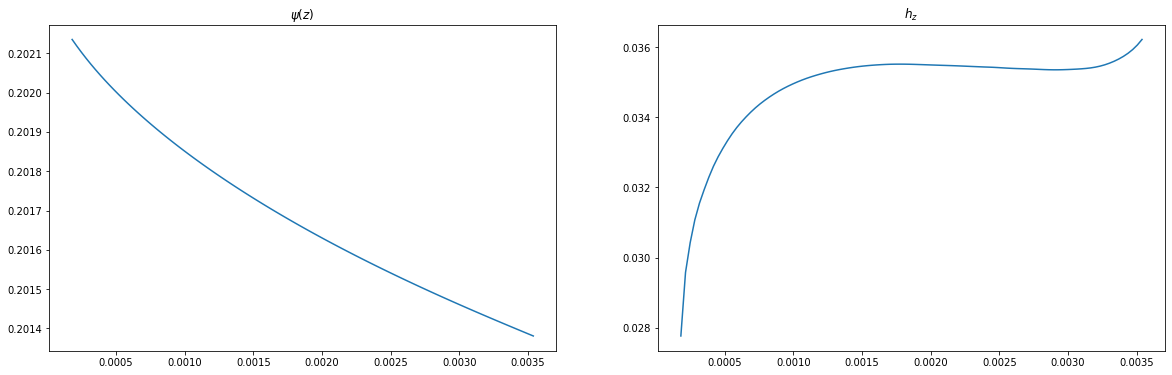

In [50]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(z2_grid, ψ)
plt.title("$\\psi(z)$")
plt.subplot(122)
plt.plot(z2_grid, h_star)
plt.title("$h_z$")

## ODE for y
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

$$
h^* = - \frac{\frac{d\phi(y)}{dy}\tilde e \sigma_y + (\eta - 1)(\gamma_1 + \gamma_2 y)\tilde e \sigma_y}{\xi_m}
$$

First order condition for $\tilde e ^*$:
$$
\frac{\delta\eta}{\tilde e} + \frac{d^2\phi(y)}{dy^2}|\sigma_y|^2\tilde e + \frac{d\phi(y)}{dy} (\theta + \sigma_y h) + (\eta - 1)(\gamma_1 + \gamma_2 y)(\theta + \sigma_y h) = 0
$$

Temporarily set $\theta = 1$ , $\sigma_y = 0$, then $h^* = 0$:
$$
\frac{\delta\eta}{e} + \frac{d\phi(y)}{dy}\theta + (\eta - 1)(\gamma_1 + \gamma_2 y)\theta = 0
$$

In [67]:
# y grid
θ = 1
num_y = 100
y_min = 0
y_max = 10
y_grid = np.linspace(y_min, y_max, num_y)
hy = y_grid[1] - y_grid[0]
# ODE for z_2
episode = 0
ϵ = .3
tol = 1e-8
lhs_error = 1
ϕ =  - δ*η*y_grid
ems = - δ*η/((η-1)*(γ1 + γ2*y_grid)*θ)
ems_old = ems
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, hy)
    dϕdyy = derivative_1d(ϕ, 2, hy)
    ems_new = - δ*η/(dϕdy*θ + (η-1)*(γ1 + γ2*y_grid)*θ)
    ems_new[ems_new <= 0] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    A = -δ*np.ones(y_grid.shape)
    B = ems*θ
    C = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η - 1)*(γ1 + γ2*y_grid)*ems*θ
    ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
    rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    ems_old = ems
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    
ϕ̃  = ϕ
ems̃ = ems

episode: 1,	 ode error: 0.0018512689842186119,	 ft error: 0.0018513449866442992
episode: 2,	 ode error: 0.0018457932795706866,	 ft error: 0.0018458663254648094
episode: 3,	 ode error: 0.0018403348038956385,	 ft error: 0.0018404447257871614
episode: 4,	 ode error: 0.0018348928091490076,	 ft error: 0.0018349863024554945
episode: 5,	 ode error: 0.0018294669891934043,	 ft error: 0.0018295493604533464
episode: 6,	 ode error: 0.0018240572271571128,	 ft error: 0.0018241324022013883
episode: 7,	 ode error: 0.0018186632584106612,	 ft error: 0.001818798797476066
episode: 8,	 ode error: 0.0018132852926397909,	 ft error: 0.001813399047015388
episode: 9,	 ode error: 0.001807923241089533,	 ft error: 0.0018080222735284014
episode: 10,	 ode error: 0.0018025770429690373,	 ft error: 0.0018026664454591848
episode: 11,	 ode error: 0.0017972466425785183,	 ft error: 0.0017973297775034209
episode: 12,	 ode error: 0.0017919319882380737,	 ft error: 0.001792010818885056
episode: 13,	 ode error: 0.00178663256539

episode: 272,	 ode error: 0.0008291588039676782,	 ft error: 0.0008294843819233363
episode: 273,	 ode error: 0.0008267034290746636,	 ft error: 0.0008270285973501861
episode: 274,	 ode error: 0.0008242553154735547,	 ft error: 0.0008245800768623875
episode: 275,	 ode error: 0.0008218144417204082,	 ft error: 0.0008221387989901241
episode: 276,	 ode error: 0.0008193807864345037,	 ft error: 0.0008197047423264918
episode: 277,	 ode error: 0.0008169543282981319,	 ft error: 0.0008172778855287481
episode: 278,	 ode error: 0.0008145350460564368,	 ft error: 0.0008148582073164157
episode: 279,	 ode error: 0.000812122918517208,	 ft error: 0.0008124456864727163
episode: 280,	 ode error: 0.0008097179245507111,	 ft error: 0.000810040301843414
episode: 281,	 ode error: 0.0008073200430894979,	 ft error: 0.000807642032336677
episode: 282,	 ode error: 0.0008049292531282233,	 ft error: 0.0008052508569234007
episode: 283,	 ode error: 0.0008025455337234643,	 ft error: 0.0008028667546362833
episode: 284,	 ode 

episode: 549,	 ode error: 0.00036447573494627155,	 ft error: 0.0003647453324428137
episode: 550,	 ode error: 0.00036339518644104975,	 ft error: 0.0003636646933845763
episode: 551,	 ode error: 0.00036231783658535093,	 ft error: 0.00036258725339475645
episode: 552,	 ode error: 0.00036124367592013,	 ft error: 0.00036151300301194106
episode: 553,	 ode error: 0.00036017269501427895,	 ft error: 0.0003604419328027501
episode: 554,	 ode error: 0.0003591048844645301,	 ft error: 0.0003593740333618367
episode: 555,	 ode error: 0.00035804023489540045,	 ft error: 0.00035830929531133204
episode: 556,	 ode error: 0.00035697873695908185,	 ft error: 0.0003572477093013079
episode: 557,	 ode error: 0.0003559203813353767,	 ft error: 0.00035618926600949896
episode: 558,	 ode error: 0.0003548651587316127,	 ft error: 0.0003551339561411182
episode: 559,	 ode error: 0.0003538130598825667,	 ft error: 0.0003540817704284864
episode: 560,	 ode error: 0.00035276407555036825,	 ft error: 0.00035303269963186484
episod

episode: 826,	 ode error: 0.00016004531628127238,	 ft error: 0.00016030040464456072
episode: 827,	 ode error: 0.0001595701265547124,	 ft error: 0.00015982518733785128
episode: 828,	 ode error: 0.00015909634453505571,	 ft error: 0.00015935137784935569
episode: 829,	 ode error: 0.00015862396605549416,	 ft error: 0.00015887897201138923
episode: 830,	 ode error: 0.00015815298696152526,	 ft error: 0.00015840796566931234
episode: 831,	 ode error: 0.00015768340311094723,	 ft error: 0.00015793835468060532
episode: 832,	 ode error: 0.00015721521037380458,	 ft error: 0.00015747013491459091
episode: 833,	 ode error: 0.0001567484046323532,	 ft error: 0.0001570033022529893
episode: 834,	 ode error: 0.0001562829817810228,	 ft error: 0.00015653785258982572
episode: 835,	 ode error: 0.0001558189377263838,	 ft error: 0.00015607378183133774
episode: 836,	 ode error: 0.00015535626838711607,	 ft error: 0.00015561108589542036
episode: 837,	 ode error: 0.00015489496969396275,	 ft error: 0.000155149760712736

episode: 1103,	 ode error: 7.016580786179229e-05,	 ft error: 7.04162419452407e-05
episode: 1104,	 ode error: 6.995695129596705e-05,	 ft error: 7.020737601004523e-05
episode: 1105,	 ode error: 6.974871383371144e-05,	 ft error: 6.999912921421918e-05
episode: 1106,	 ode error: 6.954109364114454e-05,	 ft error: 6.979149972311897e-05
episode: 1107,	 ode error: 6.933408888981207e-05,	 ft error: 6.958448570839235e-05
episode: 1108,	 ode error: 6.912769775666689e-05,	 ft error: 6.937808534696055e-05
episode: 1109,	 ode error: 6.892191842406488e-05,	 ft error: 6.917229682083341e-05
episode: 1110,	 ode error: 6.871674907973739e-05,	 ft error: 6.896711831757182e-05
episode: 1111,	 ode error: 6.851218791678257e-05,	 ft error: 6.876254803047285e-05
episode: 1112,	 ode error: 6.830823313364325e-05,	 ft error: 6.855858415736697e-05
episode: 1113,	 ode error: 6.810488293409046e-05,	 ft error: 6.835522490256096e-05
episode: 1114,	 ode error: 6.790213552723061e-05,	 ft error: 6.815246847415488e-05
episo

episode: 1380,	 ode error: 3.0670112034390015e-05,	 ft error: 3.091892717623409e-05
episode: 1381,	 ode error: 3.05850812430885e-05,	 ft error: 3.0827170851936245e-05
episode: 1382,	 ode error: 3.0503757138719426e-05,	 ft error: 3.073568666939197e-05
episode: 1383,	 ode error: 3.042266886995118e-05,	 ft error: 3.064447382146914e-05
episode: 1384,	 ode error: 3.034181576013189e-05,	 ft error: 3.055353150418124e-05
episode: 1385,	 ode error: 3.026119713448491e-05,	 ft error: 3.0462858915854728e-05
episode: 1386,	 ode error: 3.0180812320163702e-05,	 ft error: 3.0372455257036506e-05
episode: 1387,	 ode error: 3.0100660646198906e-05,	 ft error: 3.0282319729938816e-05
episode: 1388,	 ode error: 3.002074144352958e-05,	 ft error: 3.019245154038212e-05
episode: 1389,	 ode error: 2.994105404497565e-05,	 ft error: 3.0102849895944733e-05
episode: 1390,	 ode error: 2.986159778523554e-05,	 ft error: 3.0013514006425417e-05
episode: 1391,	 ode error: 2.9782372000887024e-05,	 ft error: 2.99244430843984

episode: 1655,	 ode error: 1.520864590034911e-05,	 ft error: 1.3651697268191043e-05
episode: 1656,	 ode error: 1.5172054967876316e-05,	 ft error: 1.36111652936551e-05
episode: 1657,	 ode error: 1.5135570870896233e-05,	 ft error: 1.357075359374275e-05
episode: 1658,	 ode error: 1.509919329959245e-05,	 ft error: 1.353046181170233e-05
episode: 1659,	 ode error: 1.5062921945045629e-05,	 ft error: 1.3490289591984913e-05
episode: 1660,	 ode error: 1.5026756499223089e-05,	 ft error: 1.3450236579596691e-05
episode: 1661,	 ode error: 1.4990696654981197e-05,	 ft error: 1.341030242139422e-05
episode: 1662,	 ode error: 1.4954742106032624e-05,	 ft error: 1.337048676506673e-05
episode: 1663,	 ode error: 1.4918892547006622e-05,	 ft error: 1.3330789258581e-05
episode: 1664,	 ode error: 1.4883147673382894e-05,	 ft error: 1.3291209552216781e-05
episode: 1665,	 ode error: 1.484750718151696e-05,	 ft error: 1.3251747296161298e-05
episode: 1666,	 ode error: 1.481197076865469e-05,	 ft error: 1.32124021421746

episode: 1931,	 ode error: 8.271794054126288e-06,	 ft error: 6.007574852214445e-06
episode: 1932,	 ode error: 8.255499680339187e-06,	 ft error: 5.989730653595723e-06
episode: 1933,	 ode error: 8.239253099646873e-06,	 ft error: 5.9719394302863256e-06
episode: 1934,	 ode error: 8.223054172513825e-06,	 ft error: 5.954201025652288e-06
episode: 1935,	 ode error: 8.206902759834087e-06,	 ft error: 5.936515282412014e-06
episode: 1936,	 ode error: 8.19079872287293e-06,	 ft error: 5.918882044394133e-06
episode: 1937,	 ode error: 8.174741923313482e-06,	 ft error: 5.9013011561674196e-06
episode: 1938,	 ode error: 8.15873222324414e-06,	 ft error: 5.8837724622081335e-06
episode: 1939,	 ode error: 8.142769485150773e-06,	 ft error: 5.866295807825199e-06
episode: 1940,	 ode error: 8.126853571916934e-06,	 ft error: 5.848871038142504e-06
episode: 1941,	 ode error: 8.110984346825596e-06,	 ft error: 5.831497999579198e-06
episode: 1942,	 ode error: 8.095161673543757e-06,	 ft error: 5.814176538276872e-06
epi

episode: 2205,	 ode error: 5.201700996410041e-06,	 ft error: 2.658569731491441e-06
episode: 2206,	 ode error: 5.1944248382518494e-06,	 ft error: 2.650669872853821e-06
episode: 2207,	 ode error: 5.187170090905149e-06,	 ft error: 2.64279347720701e-06
episode: 2208,	 ode error: 5.179936691581191e-06,	 ft error: 2.634940474977032e-06
episode: 2209,	 ode error: 5.172724577684213e-06,	 ft error: 2.627110796959986e-06
episode: 2210,	 ode error: 5.165533686786938e-06,	 ft error: 2.6193043735818953e-06
episode: 2211,	 ode error: 5.15836395665009e-06,	 ft error: 2.611521135731376e-06
episode: 2212,	 ode error: 5.1512153252150205e-06,	 ft error: 2.603761014944676e-06
episode: 2213,	 ode error: 5.144087730608914e-06,	 ft error: 2.5960239425730043e-06
episode: 2214,	 ode error: 5.136981111127006e-06,	 ft error: 2.5883098496900145e-06
episode: 2215,	 ode error: 5.129895405270313e-06,	 ft error: 2.5806186687571397e-06
episode: 2216,	 ode error: 5.122830551693375e-06,	 ft error: 2.5729503312181086e-06

episode: 2480,	 ode error: 3.8289413917926354e-06,	 ft error: 1.1726459491397576e-06
episode: 2481,	 ode error: 3.825709196668024e-06,	 ft error: 1.1691601585021398e-06
episode: 2482,	 ode error: 3.82248653587919e-06,	 ft error: 1.1656847251351188e-06
episode: 2483,	 ode error: 3.81927338137392e-06,	 ft error: 1.162219618137487e-06
episode: 2484,	 ode error: 3.816069705185219e-06,	 ft error: 1.1587648069781113e-06
episode: 2485,	 ode error: 3.8128754794248057e-06,	 ft error: 1.1553202611258584e-06
episode: 2486,	 ode error: 3.8096906762792072e-06,	 ft error: 1.1518859498645582e-06
episode: 2487,	 ode error: 3.8065152680442395e-06,	 ft error: 1.1484618429406328e-06
episode: 2488,	 ode error: 3.8033492270640734e-06,	 ft error: 1.145047909915468e-06
episode: 2489,	 ode error: 3.8001925257817593e-06,	 ft error: 1.1416441209055606e-06
episode: 2490,	 ode error: 3.7970451367075678e-06,	 ft error: 1.1382504456573332e-06
episode: 2491,	 ode error: 3.793907032453251e-06,	 ft error: 1.1348668539

episode: 2756,	 ode error: 3.2181844366820003e-06,	 ft error: 5.155404893727086e-07
episode: 2757,	 ode error: 3.216755351502596e-06,	 ft error: 5.140074584482809e-07
episode: 2758,	 ode error: 3.215330489440924e-06,	 ft error: 5.124789842492206e-07
episode: 2759,	 ode error: 3.2139098380397184e-06,	 ft error: 5.109550534528514e-07
episode: 2760,	 ode error: 3.2124933848816112e-06,	 ft error: 5.094356524589413e-07
episode: 2761,	 ode error: 3.2110811175785087e-06,	 ft error: 5.079207675747396e-07
episode: 2762,	 ode error: 3.2096730237846007e-06,	 ft error: 5.064103855700886e-07
episode: 2763,	 ode error: 3.208269091189422e-06,	 ft error: 5.049044934923863e-07
episode: 2764,	 ode error: 3.2068693075113473e-06,	 ft error: 5.034030769087335e-07
episode: 2765,	 ode error: 3.2054736605145046e-06,	 ft error: 5.019061234216398e-07
episode: 2766,	 ode error: 3.2040821380068234e-06,	 ft error: 5.0041361961591e-07
episode: 2767,	 ode error: 3.2026947278085936e-06,	 ft error: 4.989255522613867e-

episode: 3032,	 ode error: 2.9482961228907614e-06,	 ft error: 2.2658749645095474e-07
episode: 3033,	 ode error: 2.9476650303342927e-06,	 ft error: 2.2591348292078095e-07
episode: 3034,	 ode error: 2.947035804935728e-06,	 ft error: 2.252414736207224e-07
episode: 3035,	 ode error: 2.9464084411584806e-06,	 ft error: 2.2457146272210812e-07
episode: 3036,	 ode error: 2.9457829335193062e-06,	 ft error: 2.2390344374863721e-07
episode: 3037,	 ode error: 2.9451592765286725e-06,	 ft error: 2.232374113342317e-07
episode: 3038,	 ode error: 2.9445374647002996e-06,	 ft error: 2.2257335918762777e-07
episode: 3039,	 ode error: 2.9439174926040694e-06,	 ft error: 2.2191128166519175e-07
episode: 3040,	 ode error: 2.943299354790565e-06,	 ft error: 2.2125117312328987e-07
episode: 3041,	 ode error: 2.942683045836607e-06,	 ft error: 2.205930270856212e-07
episode: 3042,	 ode error: 2.9420685603376642e-06,	 ft error: 2.199368380935892e-07
episode: 3043,	 ode error: 2.941455892915227e-06,	 ft error: 2.192826003

episode: 3309,	 ode error: 2.828876706442978e-06,	 ft error: 9.926577809737935e-08
episode: 3310,	 ode error: 2.8285990546967656e-06,	 ft error: 9.89704065923469e-08
episode: 3311,	 ode error: 2.8283222250509703e-06,	 ft error: 9.867591382883845e-08
episode: 3312,	 ode error: 2.8280462150876047e-06,	 ft error: 9.838229712381501e-08
episode: 3313,	 ode error: 2.827771022372201e-06,	 ft error: 9.808955370171901e-08
episode: 3314,	 ode error: 2.8274966444828686e-06,	 ft error: 9.779768097203009e-08
episode: 3315,	 ode error: 2.827223079009209e-06,	 ft error: 9.750667625170925e-08
episode: 3316,	 ode error: 2.8269503235566536e-06,	 ft error: 9.721653741282903e-08
episode: 3317,	 ode error: 2.826678375720225e-06,	 ft error: 9.692726149479469e-08
episode: 3318,	 ode error: 2.826407233110775e-06,	 ft error: 9.663884609212303e-08
episode: 3319,	 ode error: 2.826136893351516e-06,	 ft error: 9.63512883367379e-08
episode: 3320,	 ode error: 2.825867354067828e-06,	 ft error: 9.606458628574899e-08
e

episode: 3584,	 ode error: 2.776596356951575e-06,	 ft error: 4.373641106688216e-08
episode: 3585,	 ode error: 2.7764735459553935e-06,	 ft error: 4.3606232606278425e-08
episode: 3586,	 ode error: 2.776351098823966e-06,	 ft error: 4.347644142847311e-08
episode: 3587,	 ode error: 2.7762290144726573e-06,	 ft error: 4.334703651576177e-08
episode: 3588,	 ode error: 2.7761072918300583e-06,	 ft error: 4.3218016665402814e-08
episode: 3589,	 ode error: 2.7759859298275794e-06,	 ft error: 4.308938067465462e-08
episode: 3590,	 ode error: 2.7758649273987995e-06,	 ft error: 4.2961127433294166e-08
episode: 3591,	 ode error: 2.775744283478815e-06,	 ft error: 4.283325564606126e-08
episode: 3592,	 ode error: 2.775623997004024e-06,	 ft error: 4.270576475784438e-08
episode: 3593,	 ode error: 2.7755040669047524e-06,	 ft error: 4.257865254819748e-08
episode: 3594,	 ode error: 2.775384492141684e-06,	 ft error: 4.245191920215774e-08
episode: 3595,	 ode error: 2.775265271665094e-06,	 ft error: 4.232556268431627

episode: 3858,	 ode error: 2.7535310681294466e-06,	 ft error: 1.9323265117628573e-08
episode: 3859,	 ode error: 2.753476611187019e-06,	 ft error: 1.9265735210864204e-08
episode: 3860,	 ode error: 2.753422315680343e-06,	 ft error: 1.9208376093408457e-08
episode: 3861,	 ode error: 2.7533681811269493e-06,	 ft error: 1.9151187950298503e-08
episode: 3862,	 ode error: 2.7533142070539085e-06,	 ft error: 1.9094169856348486e-08
episode: 3863,	 ode error: 2.75326039299046e-06,	 ft error: 1.903732181155841e-08
episode: 3864,	 ode error: 2.75320673844893e-06,	 ft error: 1.8980642705705247e-08
episode: 3865,	 ode error: 2.7531532429704835e-06,	 ft error: 1.892413226123324e-08
episode: 3866,	 ode error: 2.753099906074169e-06,	 ft error: 1.886778992303088e-08
episode: 3867,	 ode error: 2.753046727299634e-06,	 ft error: 1.8811615691098165e-08
episode: 3868,	 ode error: 2.752993706165493e-06,	 ft error: 1.875560808513773e-08
episode: 3869,	 ode error: 2.7529408422124774e-06,	 ft error: 1.86997676602610

Text(0.5, 1.0, 'ϕ(y)')

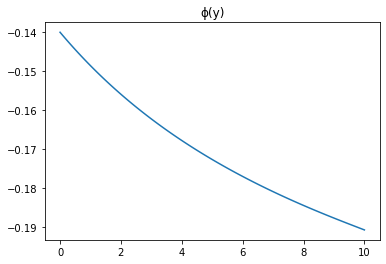

In [68]:
plt.plot(y_grid, ϕ̃ )
plt.title("ϕ(y)")

Text(0.5, 1.0, 'e(y)')

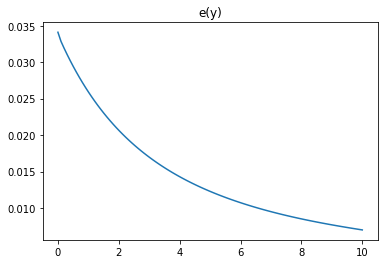

In [69]:
plt.plot(y_grid, ems̃)
plt.title("e(y)")